In [5]:
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import find_peaks
from sklearn.mixture import GaussianMixture

## dask

In [1]:
# from pathlib import Path

import dask.distributed as dd
import scanpy as sc
import anndata as ad
import h5py

sc.logging.print_header()

/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==2.1.3 scipy==1.15.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 pynndescent==0.5.13


In [2]:
cluster = dd.LocalCluster(n_workers=2)
client = dd.Client(cluster)

2025-02-13 15:26:13,097 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:40227'.
2025-02-13 15:26:13,098 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:37569'.


In [3]:
SPARSE_CHUNK_SIZE = 1_000

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 20,Total memory: 400.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46403,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 400.00 GiB
Comm: tcp://127.0.0.1:40227,Total threads: 10
Dashboard: http://127.0.0.1:45947/status,Memory: 200.00 GiB
Nanny: tcp://127.0.0.1:41495,


In [5]:
cell_atlas_path = '/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all.h5ad'

In [6]:
%%time
with h5py.File(cell_atlas_path, "r") as f:
    adata = ad.AnnData(
        obs=ad.io.read_elem(f["obs"]),
        var=ad.io.read_elem(f["var"]),
    )
    adata.X = ad.experimental.read_elem_as_dask(
        f["raw/X"], chunks=(SPARSE_CHUNK_SIZE, adata.shape[1])
    )

CPU times: user 1.39 s, sys: 993 ms, total: 2.38 s
Wall time: 4.74 s


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
%%time
adata.layers["counts"] = adata.X.copy()  # Making sure we keep access to the raw counts
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 33.7 ms, sys: 4.94 ms, total: 38.6 ms
Wall time: 64.8 ms


In [8]:
%%time
sc.pp.log1p(adata)

CPU times: user 2.29 ms, sys: 1.9 ms, total: 4.19 ms
Wall time: 79.6 ms


In [9]:
%%time
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset = True)

CPU times: user 7min 24s, sys: 5.72 s, total: 7min 30s
Wall time: 12min 3s


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
adata

AnnData object with n_obs × n_vars = 1649672 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [11]:
# adata.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_hvg.h5ad')

## pca & umap

In [2]:
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_hvg.h5ad')

/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata

AnnData object with n_obs × n_vars = 1649672 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    layers: 'counts'

In [4]:
sc.pp.pca(adata)

In [5]:
sc.pp.neighbors(adata)

/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
sc.tl.umap(adata)

/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


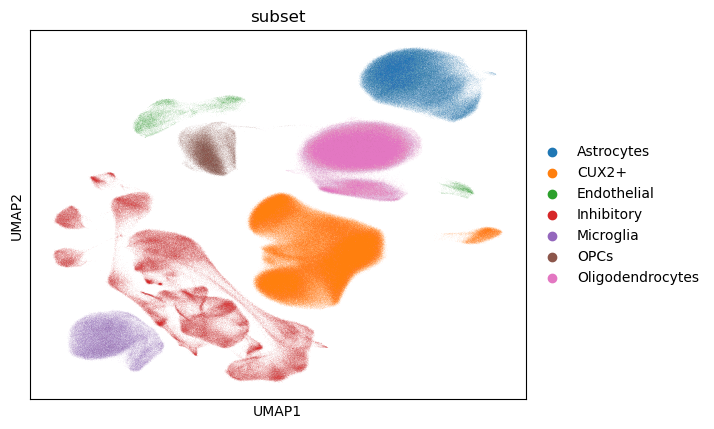

In [7]:
sc.pl.umap(adata, color = 'subset')

In [8]:
adata.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_hvg_umap.h5ad')

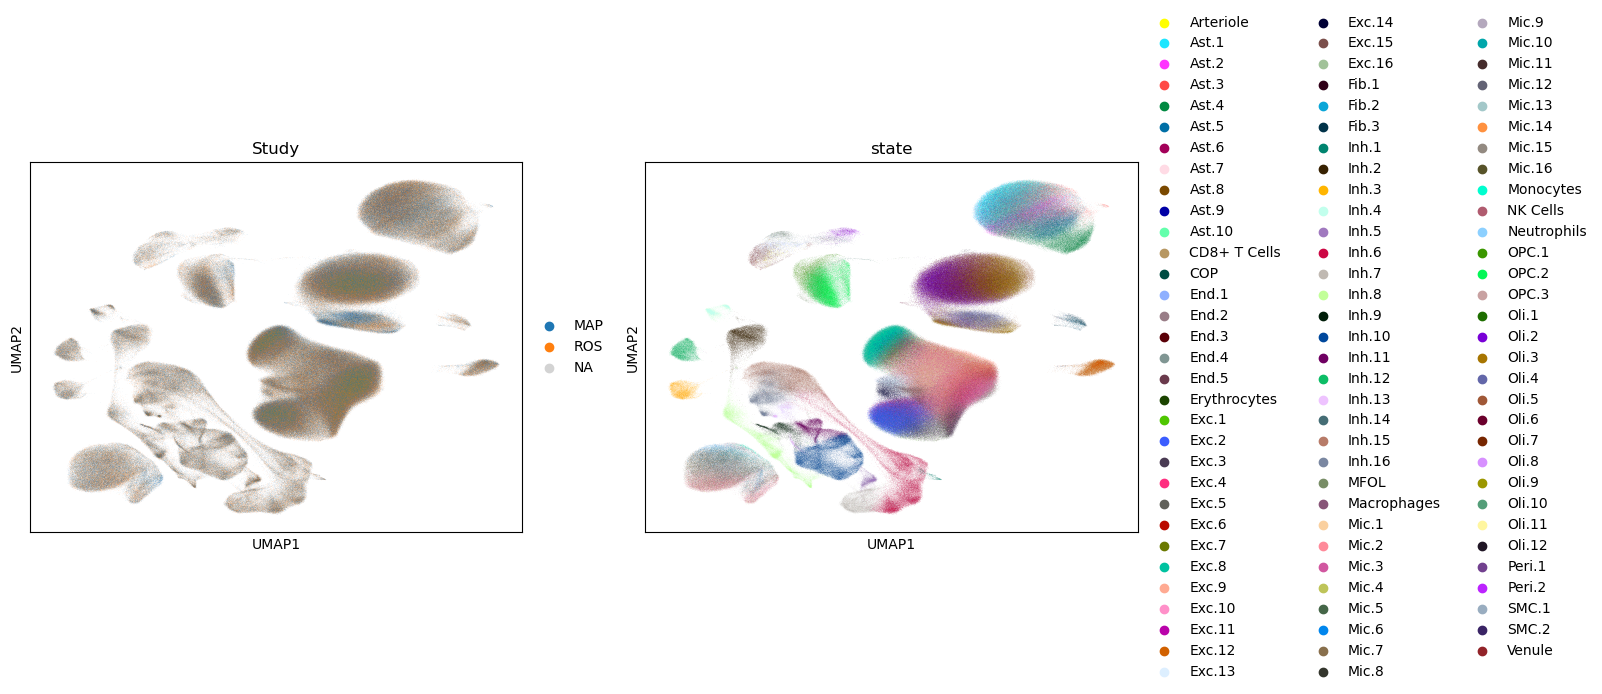

In [13]:
sc.pl.umap(adata, color = ['Study', 'state'])

In [11]:
adata.obs.batch

0          190403-B4-A
1          190403-B4-A
2          190403-B4-A
3          190403-B4-A
4          190403-B4-A
              ...     
657726    201207-B63-A
657727    201207-B63-A
657728    201207-B63-A
657729    201207-B63-B
657730     MAP50104134
Name: batch, Length: 1649672, dtype: category
Categories (127, object): ['190403-B4-A', '190403-B4-B', '190409-B5-A', '190409-B5-B', ..., 'MAP60725338', 'MAP72650337', 'MAP77143621', 'MAP84653463']

In [ ]:
np.random.choice(list(adata.obs.batch.unique()),10)

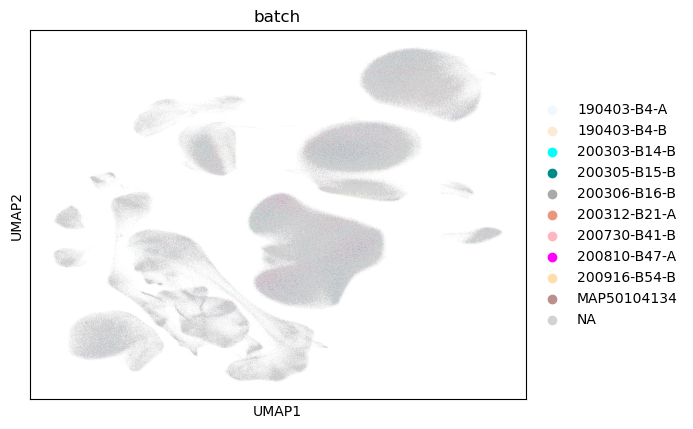

In [12]:
sc.pl.umap(adata, color = 'batch', groups = ['200303-B14-B', '200810-B47-A', '200305-B15-B', '200916-B54-B',
       '190403-B4-B', '200306-B16-B', '190403-B4-A', '200312-B21-A',
       '200730-B41-B', 'MAP50104134'], palette=list(plt.colors.CSS4_COLORS.values()))

## scvi embeddings

In [3]:
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_hvg_umap_scvi.h5ad')

/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata

AnnData object with n_obs × n_vars = 1649672 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'neighbors', 'pca', 'subset_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


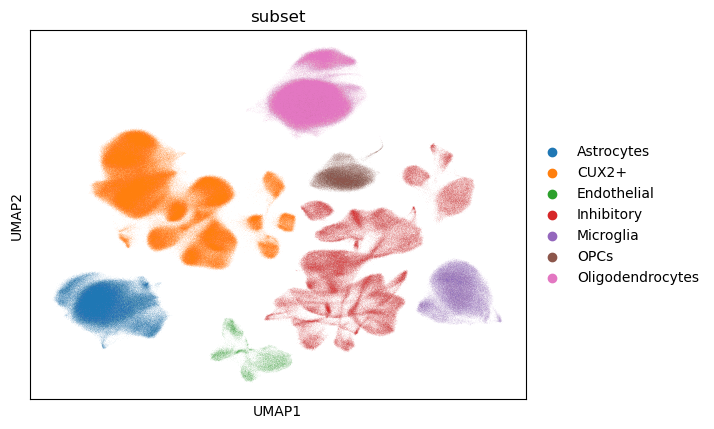

In [6]:
sc.pl.umap(adata, color = 'subset')

## concat adata

In [2]:
microglia = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/microglia.h5ad')
inhibitory = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/inhibitory.h5ad')
cux2_1 = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/cux2+.h5ad')
cux2_2 = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/cux2-.h5ad')
# astrocytes = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/astrocytes.h5ad')
# oligo = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/oligodendroglia.h5ad')
# vascular = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/vascular.niche.h5ad')


In [3]:
microglia.var = microglia.var.set_index('_index')
inhibitory.var = inhibitory.var.set_index('_index')
cux2_1.var = cux2_1.var.set_index('_index')
cux2_2.var = cux2_2.var.set_index('_index')
# astrocytes.var = astrocytes.var.set_index('_index')
# oligo.var = oligo.var.set_index('_index')
# vascular.var = vascular.var.set_index('_index')

In [3]:
# print(microglia.obs.subset.unique())
# print(inhibitory.obs.subset.unique())
# print(cux2_1.obs.subset.unique())
# print(cux2_2.obs.subset.unique())

['Microglia']
['Inhibitory']
['CUX2+']
['CUX2+']


In [4]:
half1 = ad.concat([microglia, inhibitory, cux2_1, cux2_2])
clinical = pd.read_csv('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/ROSMAP_clinical.csv')
half1.obs = pd.merge(half1.obs, clinical, on = 'individualID', how = 'left')
half1.obs['class'] = half1.obs['class'].astype(str)
half1.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/half1.h5ad')

FileNotFoundError: [Errno 2] No such file or directory: '/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/ROSMAP_clinical.csv'

In [ ]:
half1

In [4]:
half2 = ad.concat([astrocytes, oligo, vascular])
clinical = pd.read_csv('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/ROSMAP_clinical.csv')
half2.obs = pd.merge(half2.obs, clinical, on = 'individualID', how = 'left')
half2.obs['class'] = half2.obs['class'].astype(str)
half2.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/half2.h5ad')

In [2]:
half1 = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/half1.h5ad')
half2 = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/half2.h5ad')

/home/icb/zihe.zheng/miniconda3/envs/scanpy2/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/zihe.zheng/miniconda3/envs/scanpy2/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
all = ad.concat([half1, half2])
all

/home/icb/zihe.zheng/miniconda3/envs/scanpy2/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/zihe.zheng/miniconda3/envs/scanpy2/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 1649672 × 18745
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv'
    obsm: 'X_umap'

In [4]:
all.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all.h5ad')

In [3]:
print(microglia.shape)
print(inhibitory.shape)
print(cux2_1.shape)
print(cux2_2.shape)
print(astrocytes.shape)
print(oligo.shape)
print(vascular.shape)


(86612, 19183)
(257929, 20102)
(378546, 20326)
(268854, 20326)
(228925, 19874)
(409572, 19925)
(19234, 18745)


In [4]:
86612+257929+378546+268854+228925+409572+19234

1649672

## process gene variant data

### process

In [22]:
gwas = pd.read_csv('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/rosmap_genotype/GWAS_ROSMAP.csv')
twas = pd.read_csv('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/rosmap_genotype/TWAS_ROSMAP.csv')
xwas = pd.read_csv('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/rosmap_genotype/XWAS_ROSMAP.csv')

In [23]:
# align xwas and gwas labels, and then concat
gwas.rename(columns = {'Varianta': 'SNP', 'Nearest.gened':'Gene', 'Risk.allele': 'EffectAllele', 'Other.allele': 'OtherAllele'}, inplace = True)
xwas.rename(columns = {'BetaFemale': 'Beta'}, inplace = True)
xgwas = pd.concat([gwas, xwas], ignore_index=True)

In [24]:
# aggregate by gene
xgwas = xgwas.drop(columns = ['Unnamed: 0', 'SNP', 'EffectAllele', 'OtherAllele', 'REF', 'ALT', 'Beta'])
xgwas = xgwas.groupby(['Gene']).sum().T
xgwas.columns.name = None

In [47]:
xgwas

,ABCA1,ABCA7,ACE,ADAM17,ADAMTS1,ADGRG4,ANK3,ANKH,APH1B,APP,...,TNIP1,TPCN1,TREML2,TSPAN14,TSPOAP1,UMAD1,UNC5CL,USP6NL,WNT3,ZNF280C
MAP15387421,0.0438,0.0000,0.1076,0.000,0.0674,0.000,0.1094,0.0000,0.0000,0.0000,...,0.0445,0.0000,0.0,0.1408,0.0547,0.0992,0.1422,0.0662,0.1406,0.000
MAP22868024,0.0438,0.0833,0.1076,0.055,0.0337,0.000,0.1094,0.0000,0.0864,0.0445,...,0.0890,0.0000,0.0,0.1408,0.0547,0.0496,0.1422,0.0662,0.1406,0.062
MAP26637867,0.0000,0.0833,0.0538,0.000,0.0674,-0.038,0.0000,0.0000,0.0864,0.0445,...,0.0890,0.0000,0.0,0.1408,0.0547,0.0000,0.0000,0.0662,0.1406,0.031
MAP29629849,0.0438,0.0833,0.0538,0.000,0.0674,-0.038,0.0547,0.0000,0.0000,0.0000,...,0.0890,0.0000,0.0,0.0704,0.0547,0.0992,0.1422,0.0000,0.1406,0.000
MAP33332646,0.0000,0.0833,0.1076,0.000,0.0337,-0.038,0.0547,0.0000,0.0000,0.0890,...,0.0890,0.0000,0.0,0.0704,0.1094,0.0000,0.1422,0.0662,0.0703,0.031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SM-CTEND,0.0000,0.0833,0.1076,0.000,0.0337,0.000,0.1094,0.0000,0.0000,0.0445,...,0.0445,0.0000,0.0,0.1408,0.1094,0.0000,0.1422,0.1324,0.1406,0.000
SM-CTENE,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.1094,0.1277,0.0000,0.0000,...,0.0890,0.0754,0.0,0.1408,0.0547,0.0496,0.1422,0.0000,0.0703,0.000
SM-CTENF,0.0438,0.0833,0.0538,0.000,0.0000,0.000,0.1094,0.0000,0.0000,0.0445,...,0.0445,0.0754,0.0,0.1408,0.0000,0.0992,0.0711,0.0662,0.1406,0.000
SM-CTENG,0.0000,0.0000,0.1076,0.055,0.0674,-0.038,0.1094,0.1277,0.0000,0.0445,...,0.0890,0.0754,0.0,0.1408,0.1094,0.0000,0.0711,0.0662,0.0703,0.031


In [25]:
# aggregate by gene
twas = twas.drop(columns = ['Unnamed: 0', 'EQTL.ID', 'Reference', 'Alternative', 'REF', 'ALT', 'TWAS.Z'])
twas = twas.groupby(['ID.x']).sum().T
twas.columns.name = None
twas = twas.rename(columns=lambda x: x + '_twas')

In [49]:
twas

,AC004797.1_twas,AC005225.2_twas,AC008105.3_twas,AC010976.1_twas,AC013643.2_twas,AC087500.1_twas,AC097662.1_twas,AC139887.2_twas,ACE_twas,ACOT2_twas,...,YPEL3_twas,ZKSCAN1_twas,ZKSCAN3_twas,ZNF232_twas,ZNF608_twas,ZNF785_twas,ZSCAN21_twas,ZSCAN26_twas,ZSCAN31_twas,ZYX_twas
MAP15387421,5.396,-3.73905,0.0,-5.22228,0.00000,0.00000,0.00000,3.791915,-10.342,-3.68617,...,-8.83729,-10.6663,-4.0048,-9.7390,3.1979,7.2874,3.755981,-17.8338,12.3974,-4.9307
MAP22868024,10.792,0.00000,0.0,-10.44456,-4.30298,0.00000,7.37422,3.791915,-10.342,-7.37234,...,0.00000,-8.6556,-8.0096,-9.7390,3.1979,3.6437,3.755981,-35.6676,16.0188,-4.9307
MAP26637867,10.792,0.00000,0.0,-5.22228,-4.30298,0.00000,7.37422,7.583830,-5.171,0.00000,...,0.00000,-4.3278,-4.0048,-9.7390,0.0000,7.2874,3.755981,-17.8338,12.3974,-9.8614
MAP29629849,5.396,-3.73905,0.0,-5.22228,-4.30298,0.00000,7.37422,7.583830,-5.171,-3.68617,...,0.00000,-10.6663,-8.0096,-9.7390,0.0000,3.6437,3.755981,-35.6676,16.0188,0.0000
MAP33332646,5.396,-3.73905,0.0,-10.44456,-4.30298,0.00000,7.37422,3.791915,-10.342,-3.68617,...,-8.83729,-12.6770,-8.0096,-9.7390,3.1979,7.2874,7.511962,-31.3236,20.4068,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SM-CTEND,5.396,-7.47810,0.0,-10.44456,-4.30298,0.00000,7.37422,3.791915,-10.342,-7.37234,...,0.00000,-8.6556,-4.0048,-9.7390,0.0000,3.6437,3.755981,-22.1778,8.0094,-4.9307
SM-CTENE,0.000,0.00000,0.0,-5.22228,0.00000,0.00000,0.00000,7.583830,0.000,0.00000,...,-8.83729,-14.9941,-4.0048,-9.7390,0.0000,7.2874,0.000000,-17.8338,12.3974,0.0000
SM-CTENF,0.000,-7.47810,0.0,-5.22228,-4.30298,0.00000,7.37422,0.000000,-5.171,-3.68617,...,-8.83729,-8.6556,0.0000,-4.8695,3.1979,7.2874,3.755981,0.0000,8.7760,-4.9307
SM-CTENG,5.396,0.00000,0.0,-10.44456,-4.30298,0.00000,3.68711,7.583830,-10.342,0.00000,...,0.00000,-14.9941,0.0000,-4.8695,6.3958,7.2874,7.511962,0.0000,8.7760,-4.9307


In [26]:
txgwas = pd.concat([xgwas, twas], axis = 1)

In [27]:
txgwas

,ABCA1,ABCA7,ACE,ADAM17,ADAMTS1,ADGRG4,ANK3,ANKH,APH1B,APP,...,YPEL3_twas,ZKSCAN1_twas,ZKSCAN3_twas,ZNF232_twas,ZNF608_twas,ZNF785_twas,ZSCAN21_twas,ZSCAN26_twas,ZSCAN31_twas,ZYX_twas
MAP15387421,0.0438,0.0000,0.1076,0.000,0.0674,0.000,0.1094,0.0000,0.0000,0.0000,...,-8.83729,-10.6663,-4.0048,-9.7390,3.1979,7.2874,3.755981,-17.8338,12.3974,-4.9307
MAP22868024,0.0438,0.0833,0.1076,0.055,0.0337,0.000,0.1094,0.0000,0.0864,0.0445,...,0.00000,-8.6556,-8.0096,-9.7390,3.1979,3.6437,3.755981,-35.6676,16.0188,-4.9307
MAP26637867,0.0000,0.0833,0.0538,0.000,0.0674,-0.038,0.0000,0.0000,0.0864,0.0445,...,0.00000,-4.3278,-4.0048,-9.7390,0.0000,7.2874,3.755981,-17.8338,12.3974,-9.8614
MAP29629849,0.0438,0.0833,0.0538,0.000,0.0674,-0.038,0.0547,0.0000,0.0000,0.0000,...,0.00000,-10.6663,-8.0096,-9.7390,0.0000,3.6437,3.755981,-35.6676,16.0188,0.0000
MAP33332646,0.0000,0.0833,0.1076,0.000,0.0337,-0.038,0.0547,0.0000,0.0000,0.0890,...,-8.83729,-12.6770,-8.0096,-9.7390,3.1979,7.2874,7.511962,-31.3236,20.4068,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SM-CTEND,0.0000,0.0833,0.1076,0.000,0.0337,0.000,0.1094,0.0000,0.0000,0.0445,...,0.00000,-8.6556,-4.0048,-9.7390,0.0000,3.6437,3.755981,-22.1778,8.0094,-4.9307
SM-CTENE,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.1094,0.1277,0.0000,0.0000,...,-8.83729,-14.9941,-4.0048,-9.7390,0.0000,7.2874,0.000000,-17.8338,12.3974,0.0000
SM-CTENF,0.0438,0.0833,0.0538,0.000,0.0000,0.000,0.1094,0.0000,0.0000,0.0445,...,-8.83729,-8.6556,0.0000,-4.8695,3.1979,7.2874,3.755981,0.0000,8.7760,-4.9307
SM-CTENG,0.0000,0.0000,0.1076,0.055,0.0674,-0.038,0.1094,0.1277,0.0000,0.0445,...,0.00000,-14.9941,0.0000,-4.8695,6.3958,7.2874,7.511962,0.0000,8.7760,-4.9307


In [28]:
txgwas.to_csv('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/rosmap_genotype/txgwas_ROSMAP.csv')

### analyzing txgwas data

In [227]:
txgwas = pd.read_csv('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/rosmap_genotype/txgwas_ROSMAP.csv')

In [234]:
txgwas

,Unnamed: 0,ABCA1,ABCA7,ACE,ADAM17,ADAMTS1,ADGRG4,ANK3,ANKH,APH1B,...,YPEL3_twas,ZKSCAN1_twas,ZKSCAN3_twas,ZNF232_twas,ZNF608_twas,ZNF785_twas,ZSCAN21_twas,ZSCAN26_twas,ZSCAN31_twas,ZYX_twas
0,MAP15387421,0.0438,0.0000,0.1076,0.000,0.0674,0.000,0.1094,0.0000,0.0000,...,-8.83729,-10.6663,-4.0048,-9.7390,3.1979,7.2874,3.755981,-17.8338,12.3974,-4.9307
1,MAP22868024,0.0438,0.0833,0.1076,0.055,0.0337,0.000,0.1094,0.0000,0.0864,...,0.00000,-8.6556,-8.0096,-9.7390,3.1979,3.6437,3.755981,-35.6676,16.0188,-4.9307
2,MAP26637867,0.0000,0.0833,0.0538,0.000,0.0674,-0.038,0.0000,0.0000,0.0864,...,0.00000,-4.3278,-4.0048,-9.7390,0.0000,7.2874,3.755981,-17.8338,12.3974,-9.8614
3,MAP29629849,0.0438,0.0833,0.0538,0.000,0.0674,-0.038,0.0547,0.0000,0.0000,...,0.00000,-10.6663,-8.0096,-9.7390,0.0000,3.6437,3.755981,-35.6676,16.0188,0.0000
4,MAP33332646,0.0000,0.0833,0.1076,0.000,0.0337,-0.038,0.0547,0.0000,0.0000,...,-8.83729,-12.6770,-8.0096,-9.7390,3.1979,7.2874,7.511962,-31.3236,20.4068,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,SM-CTEND,0.0000,0.0833,0.1076,0.000,0.0337,0.000,0.1094,0.0000,0.0000,...,0.00000,-8.6556,-4.0048,-9.7390,0.0000,3.6437,3.755981,-22.1778,8.0094,-4.9307
1192,SM-CTENE,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.1094,0.1277,0.0000,...,-8.83729,-14.9941,-4.0048,-9.7390,0.0000,7.2874,0.000000,-17.8338,12.3974,0.0000
1193,SM-CTENF,0.0438,0.0833,0.0538,0.000,0.0000,0.000,0.1094,0.0000,0.0000,...,-8.83729,-8.6556,0.0000,-4.8695,3.1979,7.2874,3.755981,0.0000,8.7760,-4.9307
1194,SM-CTENG,0.0000,0.0000,0.1076,0.055,0.0674,-0.038,0.1094,0.1277,0.0000,...,0.00000,-14.9941,0.0000,-4.8695,6.3958,7.2874,7.511962,0.0000,8.7760,-4.9307


In [220]:
# all zeros for this gene 
txgwas['KCTD13_twas']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1191    0.0
1192    0.0
1193    0.0
1194    0.0
1195    0.0
Name: KCTD13_twas, Length: 1196, dtype: float64

In [223]:
txgwas = txgwas.drop(columns=['KCTD13_twas'])

In [251]:
correlation_matrix0 = txgwas.iloc[:, 86:116].corr()

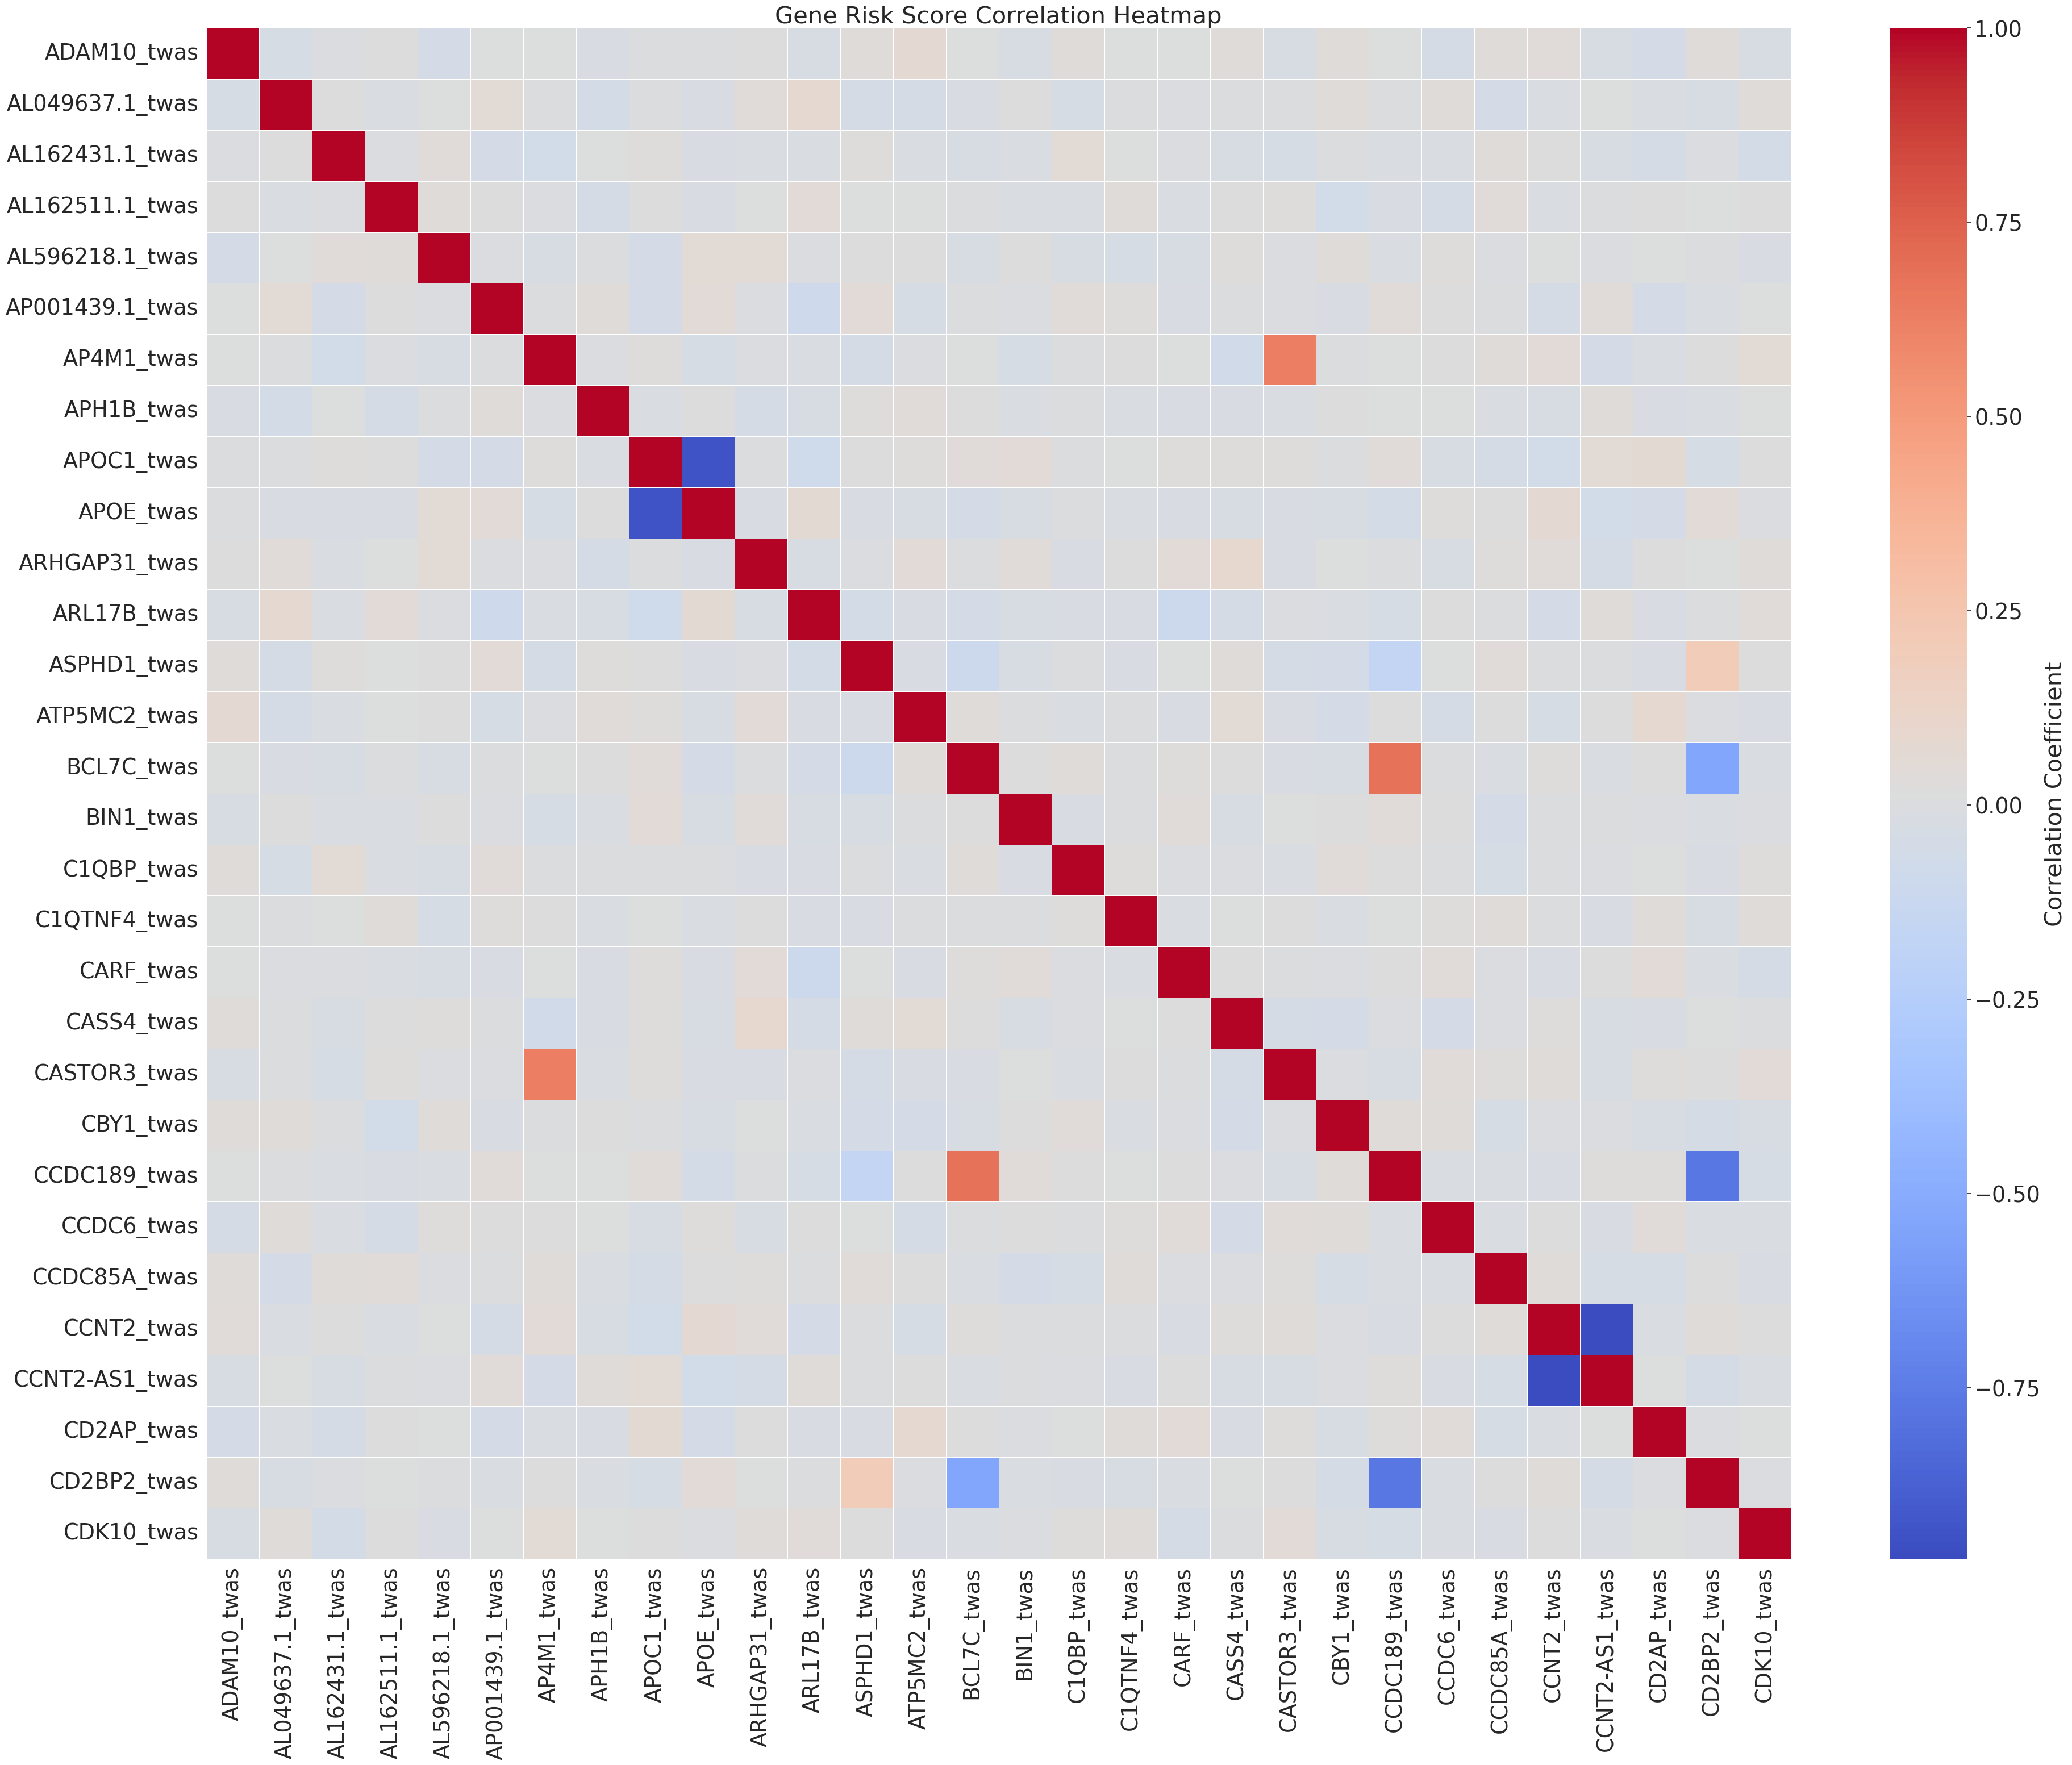

In [253]:
sns.set(font_scale=2.5)
plt.figure(figsize=(45, 35))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix0, annot=False, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Gene Risk Score Correlation Heatmap")
plt.show()

In [228]:
correlation_matrix1 = txgwas.iloc[:, 76:].corr()

In [230]:
correlation_matrix1

,AC004797.1_twas,AC005225.2_twas,AC008105.3_twas,AC010976.1_twas,AC013643.2_twas,AC087500.1_twas,AC097662.1_twas,AC139887.2_twas,ACE_twas,ACOT2_twas,...,YPEL3_twas,ZKSCAN1_twas,ZKSCAN3_twas,ZNF232_twas,ZNF608_twas,ZNF785_twas,ZSCAN21_twas,ZSCAN26_twas,ZSCAN31_twas,ZYX_twas
AC004797.1_twas,1.000000,0.018168,0.033058,-0.034550,0.000542,0.087021,-0.027879,0.011510,-0.025088,-0.011467,...,0.011957,-0.001888,0.005478,-0.065296,0.025637,-0.060235,-0.012276,-0.007269,-0.019445,-0.056898
AC005225.2_twas,0.018168,1.000000,0.021383,-0.013773,0.003335,0.020509,-0.002728,-0.017379,0.008558,0.546200,...,0.034397,-0.013214,0.045409,0.008852,-0.048494,0.033206,-0.008245,0.043954,-0.044654,0.034351
AC008105.3_twas,0.033058,0.021383,1.000000,0.005358,0.017390,0.071768,0.052435,-0.005074,-0.031136,0.041011,...,0.035744,-0.027636,0.002917,-0.030841,0.017921,0.013882,0.012402,-0.003147,-0.015829,-0.035279
AC010976.1_twas,-0.034550,-0.013773,0.005358,1.000000,-0.026942,0.058865,0.012461,0.026447,0.004900,-0.022932,...,-0.029622,-0.011297,0.002762,-0.030528,-0.018251,0.035767,0.024675,-0.000506,-0.001566,0.009318
AC013643.2_twas,0.000542,0.003335,0.017390,-0.026942,1.000000,0.037179,0.014878,0.014771,-0.016248,-0.042851,...,-0.030747,-0.010549,0.012848,0.010871,0.020670,0.014076,-0.010907,0.007911,-0.003710,-0.002799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF785_twas,-0.060235,0.033206,0.013882,0.035767,0.014076,0.006107,-0.064881,-0.007355,0.018676,0.049185,...,0.118171,0.069082,-0.031304,0.012049,-0.003430,1.000000,-0.000865,-0.021277,0.018501,-0.056707
ZSCAN21_twas,-0.012276,-0.008245,0.012402,0.024675,-0.010907,0.033575,-0.025087,-0.031618,0.005043,-0.001657,...,0.036780,0.116828,-0.020992,-0.009222,-0.015251,-0.000865,1.000000,-0.013783,0.029054,0.066621
ZSCAN26_twas,-0.007269,0.043954,-0.003147,-0.000506,0.007911,-0.020171,-0.026424,-0.022200,-0.011205,0.012726,...,0.001610,0.019068,0.930005,0.057346,0.041908,-0.021277,-0.013783,1.000000,-0.772346,0.022379
ZSCAN31_twas,-0.019445,-0.044654,-0.015829,-0.001566,-0.003710,-0.011663,0.009534,-0.004777,-0.030911,-0.015207,...,0.015699,-0.011403,-0.920079,-0.043095,-0.016724,0.018501,0.029054,-0.772346,1.000000,-0.012658


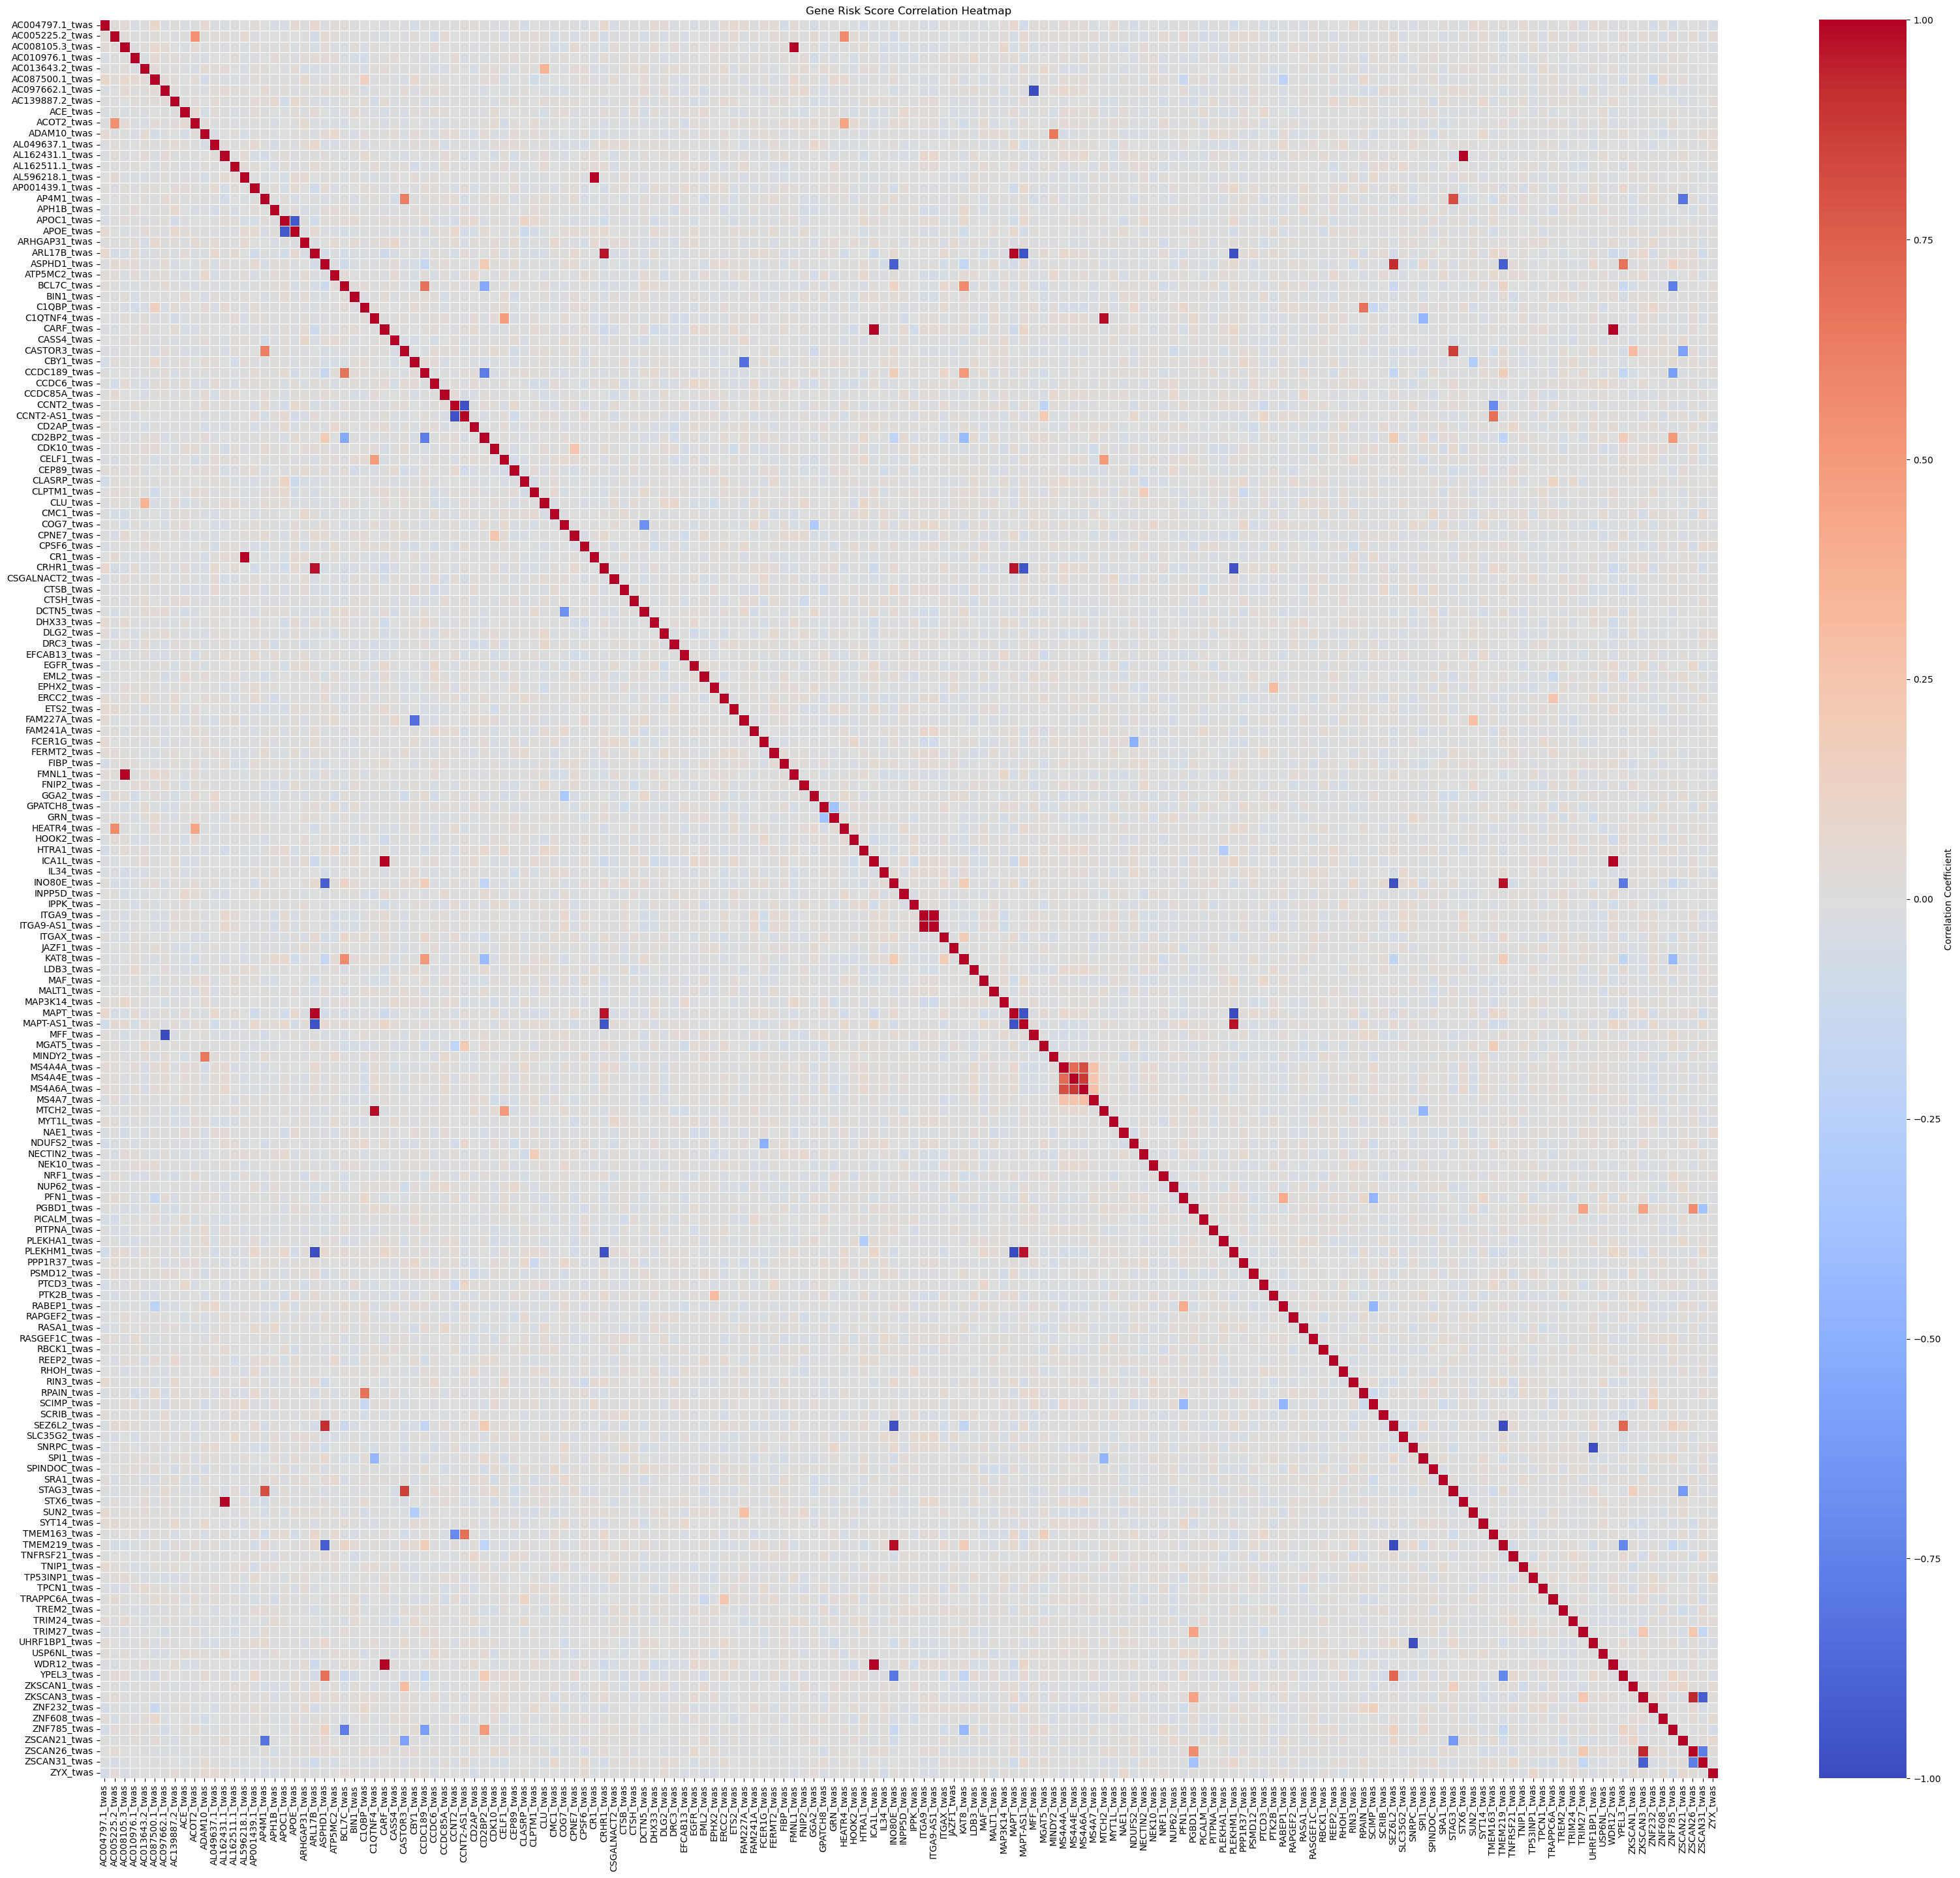

In [232]:
plt.figure(figsize=(40, 35))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix1, annot=False, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Gene Risk Score Correlation Heatmap")
plt.show()

In [239]:
correlation_matrix2 = txgwas.drop(columns=['Unnamed: 0']).iloc[:, :75].corr()

In [240]:
correlation_matrix2

,ABCA1,ABCA7,ACE,ADAM17,ADAMTS1,ADGRG4,ANK3,ANKH,APH1B,APP,...,TNIP1,TPCN1,TREML2,TSPAN14,TSPOAP1,UMAD1,UNC5CL,USP6NL,WNT3,ZNF280C
ABCA1,1.000000,0.040035,0.027140,0.014206,0.026639,-0.001398,0.047411,-0.037494,-0.061656,-0.023360,...,-0.023079,-0.066763,-0.038927,-0.044947,-0.073149,0.017946,0.012245,-0.011820,-0.019403,-0.003296
ABCA7,0.040035,1.000000,-0.019772,0.031105,0.005628,-0.021980,-0.008034,0.017878,-0.016695,0.002642,...,0.001762,0.022649,0.015312,0.034198,-0.033207,0.021301,0.048516,0.001377,-0.037843,0.031209
ACE,0.027140,-0.019772,1.000000,-0.052933,0.024332,0.019056,0.048738,0.010407,-0.003478,-0.011265,...,0.003500,-0.022543,-0.045206,-0.042677,0.040460,0.021884,0.002727,-0.051356,-0.006434,0.077048
ADAM17,0.014206,0.031105,-0.052933,1.000000,0.003848,0.014046,-0.024795,-0.023611,-0.026203,-0.071865,...,0.011263,-0.043358,0.029860,-0.013207,-0.028613,-0.019565,0.007607,0.059285,0.007260,0.007336
ADAMTS1,0.026639,0.005628,0.024332,0.003848,1.000000,0.049653,-0.018955,-0.052265,0.037307,-0.045306,...,0.023484,0.001083,0.008186,-0.052859,0.009406,0.019038,0.035147,0.060351,-0.012660,-0.001371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UMAD1,0.017946,0.021301,0.021884,-0.019565,0.019038,-0.026033,0.006234,-0.011010,-0.014914,-0.026827,...,-0.047493,0.040871,0.020010,0.039531,-0.004353,1.000000,0.052901,-0.023021,0.028208,-0.053304
UNC5CL,0.012245,0.048516,0.002727,0.007607,0.035147,0.047444,0.066718,0.014098,-0.021892,0.025819,...,-0.075222,0.013281,0.043902,0.005456,-0.041765,0.052901,1.000000,-0.002496,-0.022648,-0.004880
USP6NL,-0.011820,0.001377,-0.051356,0.059285,0.060351,0.027845,-0.022858,0.022926,0.018304,0.008056,...,-0.027207,-0.010157,-0.005806,-0.051557,0.026296,-0.023021,-0.002496,1.000000,-0.018189,0.011955
WNT3,-0.019403,-0.037843,-0.006434,0.007260,-0.012660,0.026814,-0.018329,0.004757,-0.022860,0.066233,...,-0.027808,-0.021279,0.007564,0.009581,0.004783,0.028208,-0.022648,-0.018189,1.000000,-0.025766


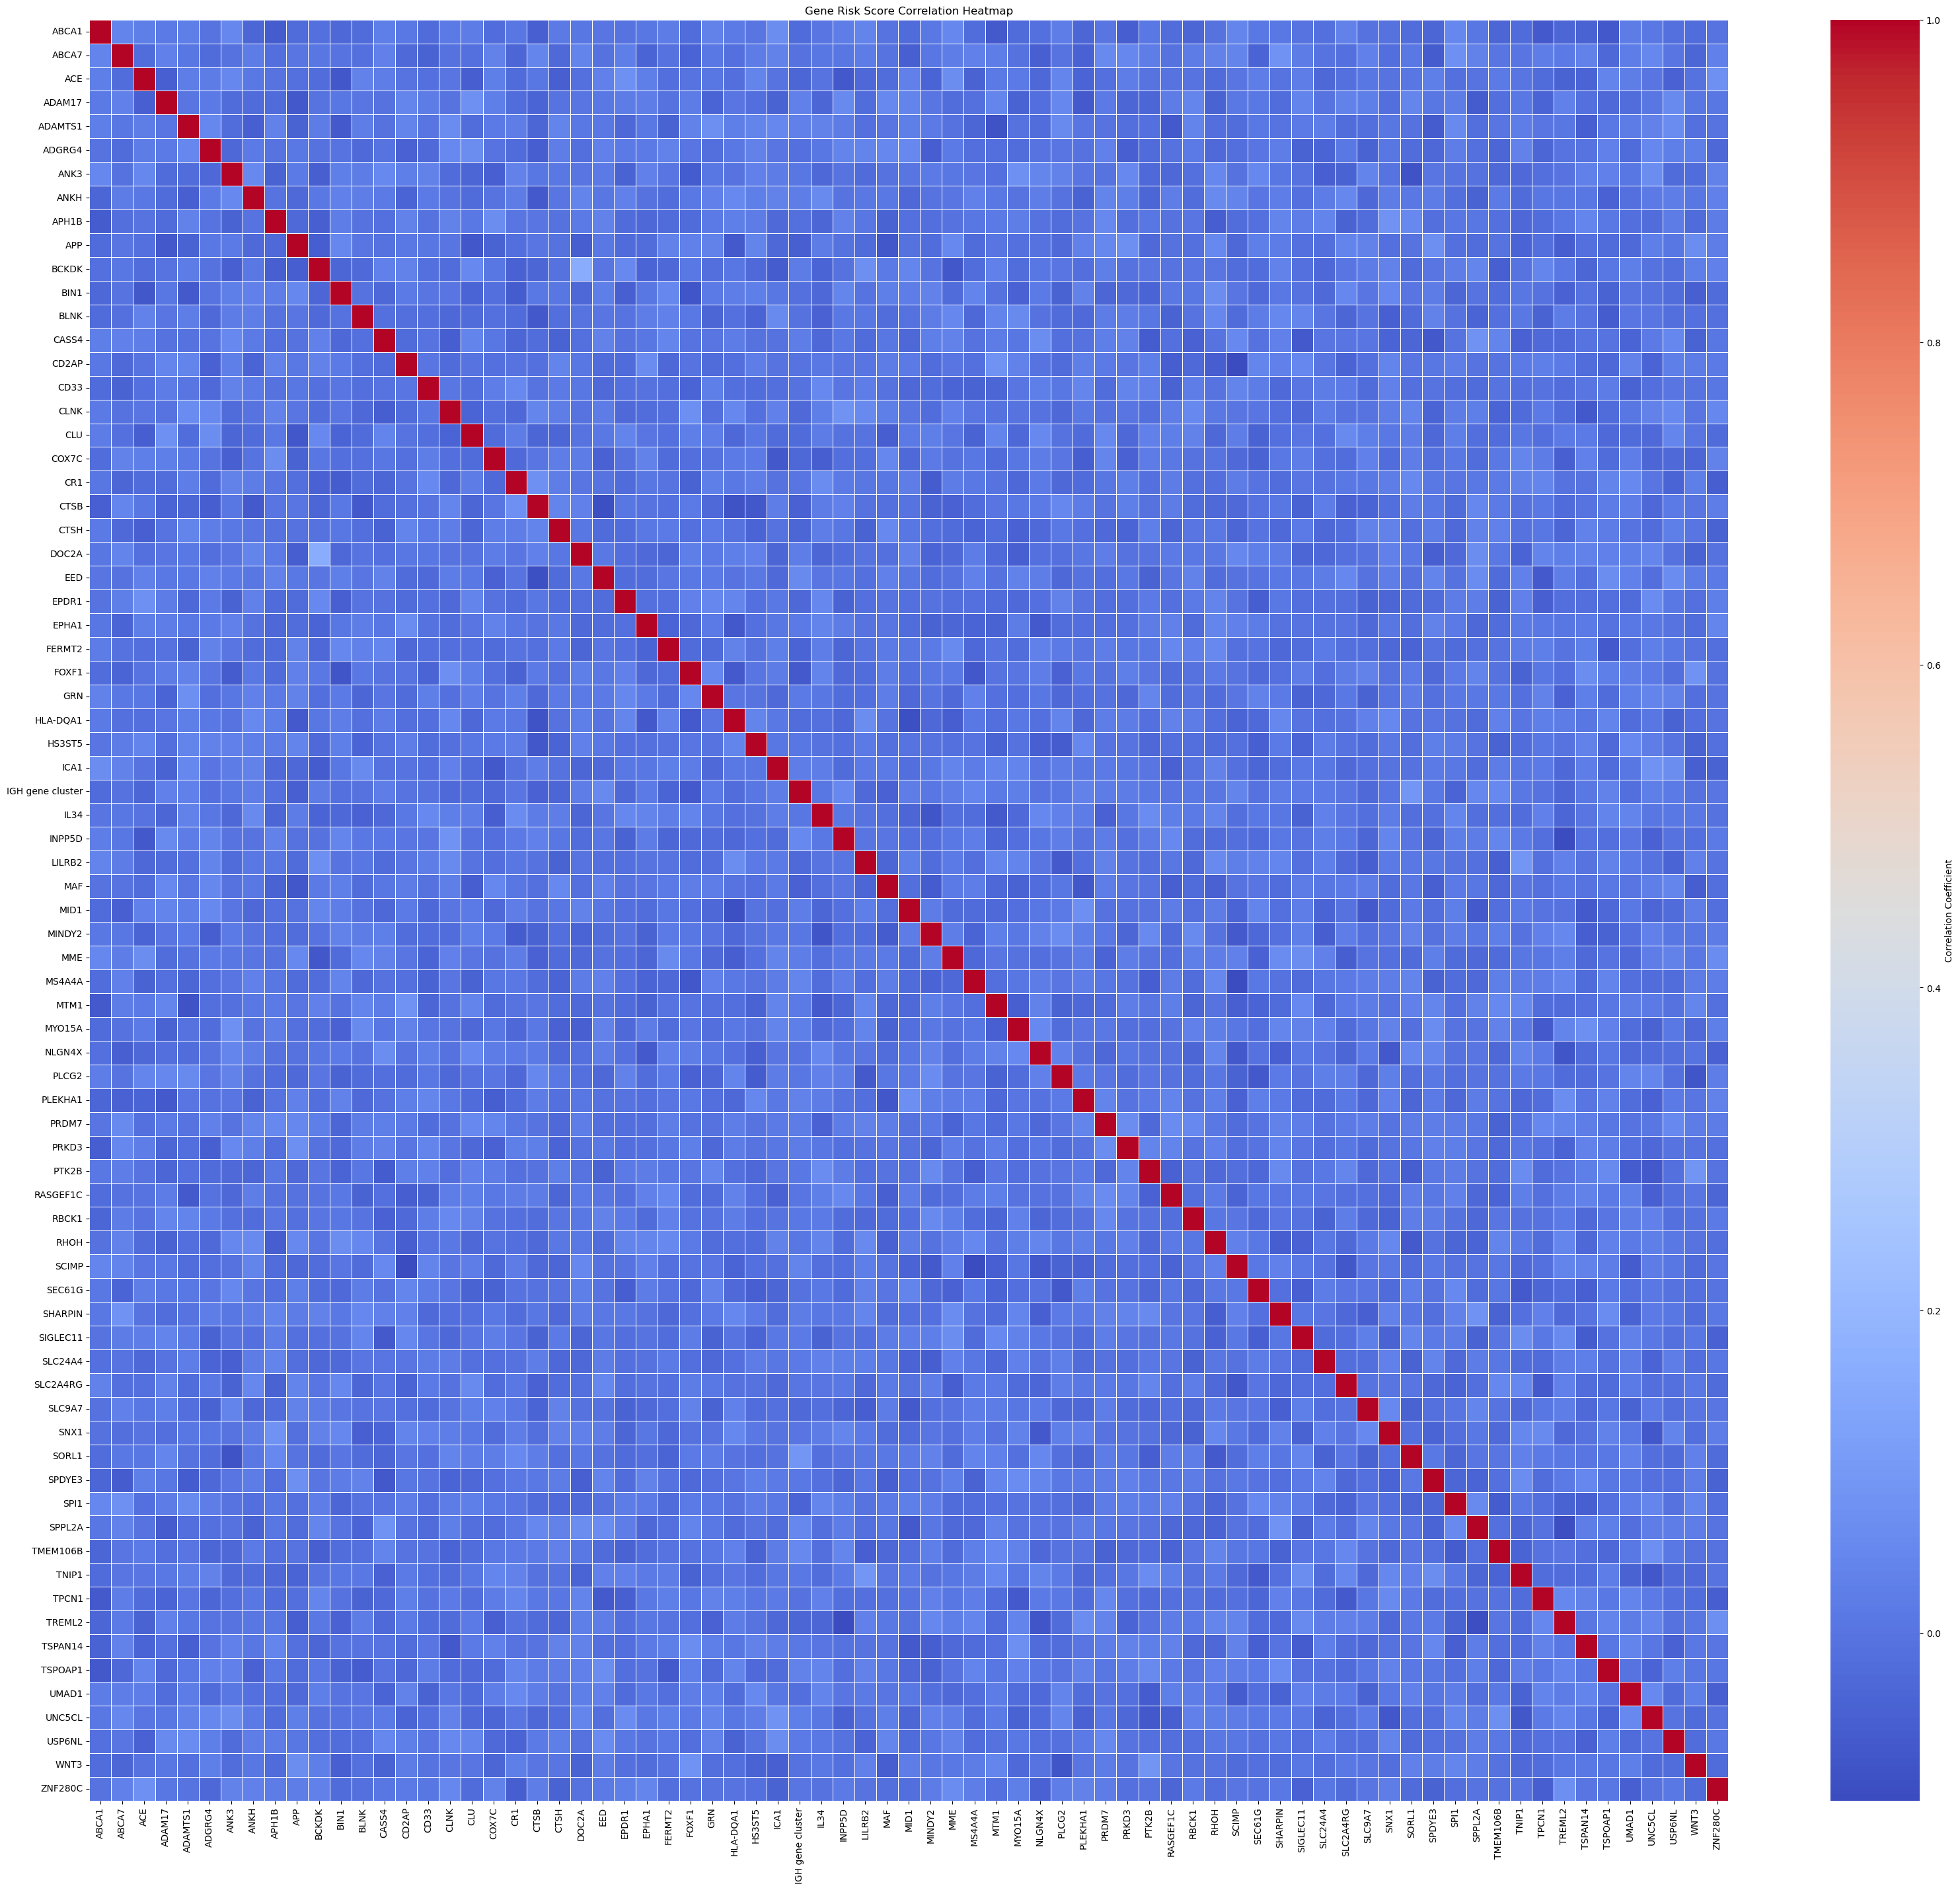

In [241]:
plt.figure(figsize=(40, 35))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix2, annot=False, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Gene Risk Score Correlation Heatmap")
plt.show()

### add variant info to adata

In [2]:
txgwas = pd.read_csv('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/rosmap_genotype/txgwas_ROSMAP.csv')
txgwas.head()

,Unnamed: 0,ABCA1,ABCA7,ACE,ADAM17,ADAMTS1,ADGRG4,ANK3,ANKH,APH1B,...,YPEL3_twas,ZKSCAN1_twas,ZKSCAN3_twas,ZNF232_twas,ZNF608_twas,ZNF785_twas,ZSCAN21_twas,ZSCAN26_twas,ZSCAN31_twas,ZYX_twas
0,MAP15387421,0.0438,0.0000,0.1076,0.000,0.0674,0.000,0.1094,0.0,0.0000,...,-8.83729,-10.6663,-4.0048,-9.739,3.1979,7.2874,3.755981,-17.8338,12.3974,-4.9307
1,MAP22868024,0.0438,0.0833,0.1076,0.055,0.0337,0.000,0.1094,0.0,0.0864,...,0.00000,-8.6556,-8.0096,-9.739,3.1979,3.6437,3.755981,-35.6676,16.0188,-4.9307
2,MAP26637867,0.0000,0.0833,0.0538,0.000,0.0674,-0.038,0.0000,0.0,0.0864,...,0.00000,-4.3278,-4.0048,-9.739,0.0000,7.2874,3.755981,-17.8338,12.3974,-9.8614
3,MAP29629849,0.0438,0.0833,0.0538,0.000,0.0674,-0.038,0.0547,0.0,0.0000,...,0.00000,-10.6663,-8.0096,-9.739,0.0000,3.6437,3.755981,-35.6676,16.0188,0.0000
4,MAP33332646,0.0000,0.0833,0.1076,0.000,0.0337,-0.038,0.0547,0.0,0.0000,...,-8.83729,-12.6770,-8.0096,-9.739,3.1979,7.2874,7.511962,-31.3236,20.4068,0.0000


In [3]:
# removed bad/na samples in disease_pre_rosmap.ipynb
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_ready.h5ad')

/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
adata

AnnData object with n_obs × n_vars = 1625707 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', '_scvi_batch', '_scvi_labels', 'AD', 'apoe_label'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'neighbors', 'pca', 'state_colors', 'subset_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
# read the mapping file, and drop NA and duplicates
biospeciman = pd.read_csv('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/metadata/ROSMAP_biospecimen_metadata.csv')
biospeciman.dropna(subset = ['individualID', 'specimenID'], inplace = True)
biospeciman.drop_duplicates(subset = ['individualID', 'specimenID'], inplace = True)

In [6]:
# do the individual ID and specimen ID map to the adata and txgwas dfs?
print(len(set(biospeciman.individualID).intersection(adata.obs.individualID)))
print(len(set(biospeciman.specimenID).intersection(txgwas['Unnamed: 0'])))

449
1189


In [7]:
# individualID and specimenID are not a one-on-one map, but each specimen only map to a single individual
display(biospeciman[['individualID', 'specimenID']].groupby(by = ['individualID']).count().head())
display(biospeciman[['individualID', 'specimenID']].groupby(by = ['specimenID']).count().head())

,specimenID
individualID,
BC15_Control,1
R1004922,1
R1012422,5
R1014260,1
R1015854,12


,individualID
specimenID,
01_120405,1
02_120405,1
03_120405,1
04_120405,1
05_120405,1


In [8]:
# create a mapping from specimen ID to individual ID
match_dict = dict(zip(biospeciman.specimenID, biospeciman.individualID))
txgwas['individualID'] = txgwas['Unnamed: 0'].map(match_dict)
txgwas.rename(columns = {'Unnamed: 0': 'specimenID'}, inplace = True)

In [9]:
merged = pd.merge(adata.obs, txgwas)

In [10]:
print(len(txgwas.specimenID.unique())) # number of specimens in the variant data
print(len(adata.obs.individualID.unique())) # number of individuals in the single-cell data
print(len(merged.specimenID.unique())) # number of specimens in the merged data, 7 more because 1 to 2 mapping
print(len(merged.individualID.unique())) # number of individuals in the merged data

1196
449
444
437


In [11]:
# there are 7 patients that has 2 specimens corresponding to them
counts = merged[['individualID', 'specimenID']].drop_duplicates().groupby(by = ['individualID']).count()
counts[counts.specimenID>1].index

Index(['R3257830', 'R4990009', 'R6478102', 'R7483736', 'R7874995', 'R8444624',
       'R9255058'],
      dtype='object', name='individualID')

In [24]:
list(txgwas[txgwas.individualID == 'R3257830'].specimenID)[0]

'SM-CJFNH'

In [25]:
for individualID in counts[counts.specimenID>1].index:
    print('Answering for...', individualID)
    specimens = list(txgwas[txgwas.individualID == individualID].specimenID)
    print(specimens)
    first = txgwas[txgwas.individualID == individualID].drop(columns = ['specimenID', 'individualID']).reset_index(drop = True).iloc[0]
    second = txgwas[txgwas.individualID == individualID].drop(columns = ['specimenID', 'individualID']).reset_index(drop = True).iloc[1]
    print('Are the two specimen for the individual same?')
    print(first.corr(second))

Answering for... R3257830
['SM-CJFNH', 'SM-CTED9']
Are the two specimen for the individual same?
1.0
Answering for... R4990009
['SM-CJGGL', 'SM-CTEN3']
Are the two specimen for the individual same?
0.9999999179653191
Answering for... R6478102
['ROS20376029', 'SM-CJEFR']
Are the two specimen for the individual same?
1.0
Answering for... R7483736
['SM-CJEHE', 'SM-CTEDY']
Are the two specimen for the individual same?
0.6884292667603682
Answering for... R7874995
['SM-CJK4Y', 'SM-CTEI8']
Are the two specimen for the individual same?
1.0
Answering for... R8444624
['SM-CJEFV', 'SM-CTEMN']
Are the two specimen for the individual same?
0.9999999999999999
Answering for... R9255058
['MAP22868024', 'SM-CJIYD']
Are the two specimen for the individual same?
1.0


In [ ]:
# process data and txgwas based on the duplicates

In [28]:
# drop the low quality individual with very different variant for their two samples
adata = adata[adata.obs.individualID != 'R7483736']

In [29]:
# for individuals with multiple specimen ids, and have similar variant data, drop the second one
txgwas = txgwas[~txgwas.specimenID.isin(['SM-CTED9', 'SM-CTEN3', 'SM-CJEFR', 'SM-CTEI8', 'SM-CTEMN', 'SM-CJIYD'])].reset_index(drop = True)

In [33]:
merged = pd.merge(adata.obs, txgwas, how = 'left')

In [34]:
print(len(txgwas.specimenID.unique())) # number of specimens in the variant data
print(len(adata.obs.individualID.unique())) # number of individuals in the single-cell data
print(len(merged.specimenID.unique())) # number of specimens in the merged data, 7 more because 1 to 2 mapping
print(len(merged.individualID.unique())) # number of individuals in the merged data

1190
448
437
448


In [35]:
adata.obs = merged

In [40]:
adata = adata[~adata.obs['specimenID'].isna()].copy()

/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [41]:
adata

AnnData object with n_obs × n_vars = 1581199 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', '_scvi_batch', '_scvi_labels', 'AD', 'apoe_label', 'specimenID', 'ABCA1', 'ABCA7', 'ACE', 'ADAM17', 'ADAMTS1', 'ADGRG4', 'ANK3', 'ANKH', 'APH1B', 'APP', 'BCKDK', 'BIN1', 'BLNK', 'CASS4', 'CD2AP', 'CD33', 'CLNK', 'CLU', 'COX7C', 'CR1', 'CTSB', 'CTSH', 'DOC2A', 'EED', 'EPDR1', 'EPHA1', 'FERMT2', 'FOXF1', 'GRN', 'HLA-DQA1', 'HS3ST5', 'ICA1', 'IGH gene cluster', 'IL34', 'INPP5D', 'LILRB2', 'MAF', 'MID1', 'MINDY2', 'MME', 'MS4A4A', 'MTM1', 'MYO15A', 'NLGN4X', 'PLCG2', 'PLEKHA1', 'PRDM7', 'PRKD3', 'PTK2B', 'RASGEF1C', 'RBCK1', 'RHOH', 'SCIMP', 'SEC61G', 'SHARPIN', 'SIGLEC11', 'SLC24A4',

In [42]:
len(adata.obs.individualID.unique())

436

In [43]:
len(adata.obs.specimenID.unique())

436

In [55]:
obs_ = adata.obs

In [56]:
obs_ = obs_[['individualID', 'specimenID']].drop_duplicates().reset_index(drop = True)

In [58]:
obs_.to_csv('rosmap_obs.csv', index = False)

In [48]:
adata.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_ready_variant.h5ad')

## Analyzing the variant risk score

In [6]:
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_ready_variant.h5ad')

In [7]:
adata.obs.reset_index(inplace = True, drop = True)

In [8]:
adata

AnnData object with n_obs × n_vars = 1581199 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', '_scvi_batch', '_scvi_labels', 'AD', 'apoe_label', 'specimenID', 'ABCA1', 'ABCA7', 'ACE', 'ADAM17', 'ADAMTS1', 'ADGRG4', 'ANK3', 'ANKH', 'APH1B', 'APP', 'BCKDK', 'BIN1', 'BLNK', 'CASS4', 'CD2AP', 'CD33', 'CLNK', 'CLU', 'COX7C', 'CR1', 'CTSB', 'CTSH', 'DOC2A', 'EED', 'EPDR1', 'EPHA1', 'FERMT2', 'FOXF1', 'GRN', 'HLA-DQA1', 'HS3ST5', 'ICA1', 'IGH gene cluster', 'IL34', 'INPP5D', 'LILRB2', 'MAF', 'MID1', 'MINDY2', 'MME', 'MS4A4A', 'MTM1', 'MYO15A', 'NLGN4X', 'PLCG2', 'PLEKHA1', 'PRDM7', 'PRKD3', 'PTK2B', 'RASGEF1C', 'RBCK1', 'RHOH', 'SCIMP', 'SEC61G', 'SHARPIN', 'SIGLEC11', 'SLC24A4',

In [9]:
genes = adata.obs.iloc[:, 32:].columns

In [21]:
adata.obs.iloc[:, 32:]

,ABCA1,ABCA7,ACE,ADAM17,ADAMTS1,ADGRG4,ANK3,ANKH,APH1B,APP,...,YPEL3_twas,ZKSCAN1_twas,ZKSCAN3_twas,ZNF232_twas,ZNF608_twas,ZNF785_twas,ZSCAN21_twas,ZSCAN26_twas,ZSCAN31_twas,ZYX_twas
0,0.0000,0.0833,0.0538,0.055,0.0674,-0.076,0.0547,0.0000,0.0864,0.0000,...,-8.83729,-14.9941,0.0000,-9.7390,3.1979,7.2874,3.755981,0.0000,8.7760,-4.9307
1,0.0000,0.0000,0.0538,0.000,0.0674,0.000,0.1094,0.0000,0.0000,0.0445,...,-8.83729,-17.0048,0.0000,-9.7390,6.3958,7.2874,3.755981,0.0000,8.7760,0.0000
2,0.0000,0.0833,0.0538,0.000,0.0337,-0.076,0.1094,0.0000,0.0864,0.0445,...,-8.83729,-14.9941,-4.0048,-4.8695,3.1979,7.2874,0.000000,-17.8338,12.3974,0.0000
3,0.0000,0.0833,0.0538,0.000,0.0674,0.000,0.1094,0.0000,0.0000,0.0445,...,-8.83729,-10.6663,-4.0048,-9.7390,3.1979,7.2874,3.755981,-17.8338,12.3974,0.0000
4,0.0000,0.0833,0.0000,0.000,0.0674,0.000,0.0547,0.0000,0.0000,0.0890,...,-8.83729,-8.6556,-4.0048,-9.7390,0.0000,7.2874,3.755981,-17.8338,12.3974,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581194,0.0000,0.0000,0.1076,0.000,0.0674,0.000,0.0547,0.0000,0.0864,0.0890,...,-8.83729,-8.6556,0.0000,-9.7390,0.0000,7.2874,3.755981,-13.4898,8.7760,-4.9307
1581195,0.0438,0.1666,0.1076,0.000,0.0674,0.000,0.0547,0.0000,0.0864,0.0445,...,-17.67458,-8.6556,-4.0048,-9.7390,3.1979,7.2874,3.755981,-22.1778,8.0094,-4.9307
1581196,0.0438,0.1666,0.1076,0.000,0.0674,0.000,0.0547,0.0000,0.0864,0.0445,...,-17.67458,-8.6556,-4.0048,-9.7390,3.1979,7.2874,3.755981,-22.1778,8.0094,-4.9307
1581197,0.0000,0.0000,0.1076,0.000,0.0337,-0.038,0.1094,0.0000,0.0000,0.0445,...,0.00000,0.0000,-8.0096,-9.7390,6.3958,3.6437,7.511962,-17.8338,20.4068,0.0000


### violin plots of risk scores

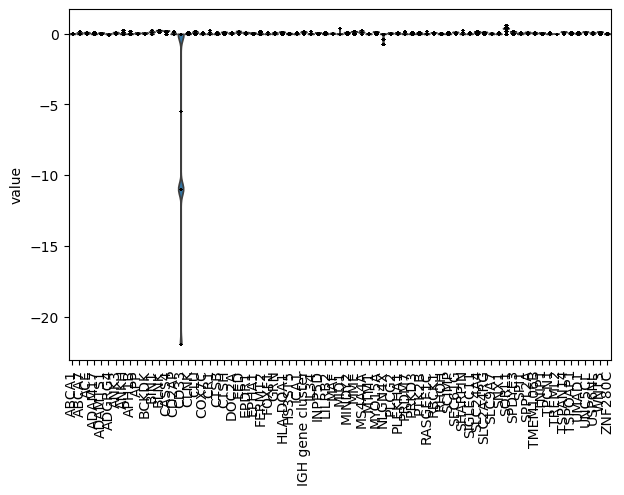

In [23]:
sc.pl.violin(adata, keys=['ABCA1', 'ABCA7', 'ACE', 'ADAM17', 'ADAMTS1', 'ADGRG4', 'ANK3', 'ANKH', 'APH1B', 'APP', 'BCKDK', 'BIN1', 'BLNK', 'CASS4', 'CD2AP', 'CD33', 
                          'CLNK', 'CLU', 'COX7C', 'CR1', 'CTSB', 'CTSH', 'DOC2A', 'EED', 'EPDR1', 'EPHA1', 'FERMT2', 'FOXF1', 'GRN', 'HLA-DQA1', 'HS3ST5', 'ICA1', 
                          'IGH gene cluster', 'IL34', 'INPP5D', 'LILRB2', 'MAF', 'MID1', 'MINDY2', 'MME', 'MS4A4A', 'MTM1', 'MYO15A', 'NLGN4X', 'PLCG2', 'PLEKHA1', 
                          'PRDM7', 'PRKD3', 'PTK2B', 'RASGEF1C', 'RBCK1', 'RHOH', 'SCIMP', 'SEC61G', 'SHARPIN', 'SIGLEC11', 'SLC24A4', 'SLC2A4RG', 'SLC9A7', 'SNX1', 
                          'SORL1', 'SPDYE3', 'SPI1', 'SPPL2A', 'TMEM106B', 'TNIP1', 'TPCN1', 'TREML2', 'TSPAN14', 'TSPOAP1', 'UMAD1', 'UNC5CL', 'USP6NL', 'WNT3', 
                          'ZNF280C', ], rotation = 90)

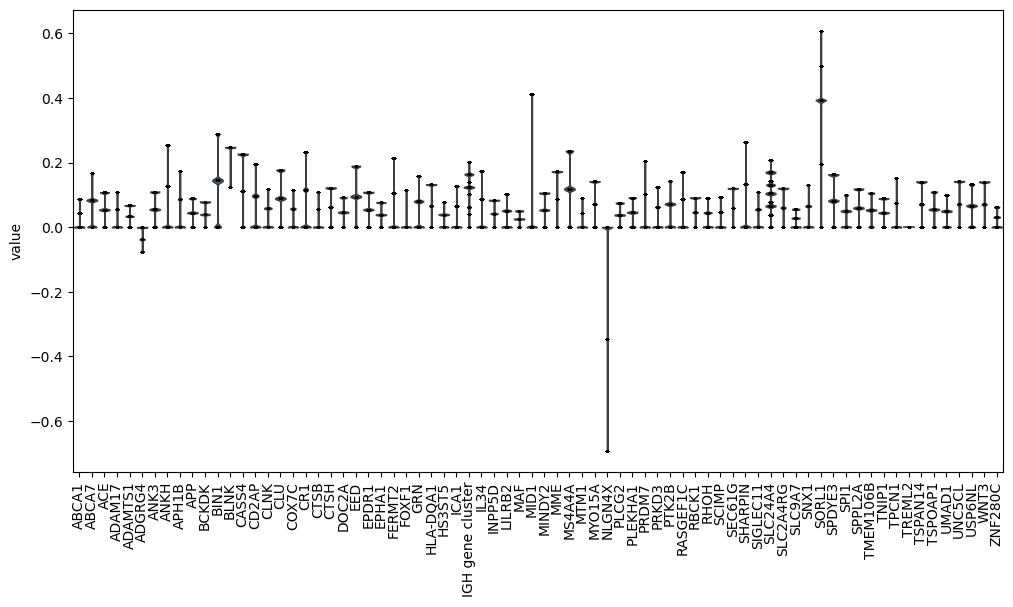

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
sc.pl.violin(adata, keys=['ABCA1', 'ABCA7', 'ACE', 'ADAM17', 'ADAMTS1', 'ADGRG4', 'ANK3', 'ANKH', 'APH1B', 'APP', 'BCKDK', 'BIN1', 'BLNK', 'CASS4', 'CD2AP', 
                          'CLNK', 'CLU', 'COX7C', 'CR1', 'CTSB', 'CTSH', 'DOC2A', 'EED', 'EPDR1', 'EPHA1', 'FERMT2', 'FOXF1', 'GRN', 'HLA-DQA1', 'HS3ST5', 'ICA1', 
                          'IGH gene cluster', 'IL34', 'INPP5D', 'LILRB2', 'MAF', 'MID1', 'MINDY2', 'MME', 'MS4A4A', 'MTM1', 'MYO15A', 'NLGN4X', 'PLCG2', 'PLEKHA1', 
                          'PRDM7', 'PRKD3', 'PTK2B', 'RASGEF1C', 'RBCK1', 'RHOH', 'SCIMP', 'SEC61G', 'SHARPIN', 'SIGLEC11', 'SLC24A4', 'SLC2A4RG', 'SLC9A7', 'SNX1', 
                          'SORL1', 'SPDYE3', 'SPI1', 'SPPL2A', 'TMEM106B', 'TNIP1', 'TPCN1', 'TREML2', 'TSPAN14', 'TSPOAP1', 'UMAD1', 'UNC5CL', 'USP6NL', 'WNT3', 
                          'ZNF280C', ], rotation = 90, ax=ax)

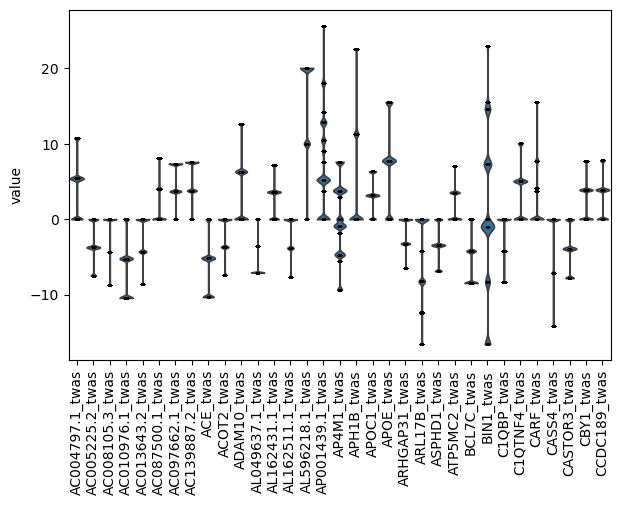

In [24]:
sc.pl.violin(adata, keys=['AC004797.1_twas', 'AC005225.2_twas', 'AC008105.3_twas', 'AC010976.1_twas', 'AC013643.2_twas', 'AC087500.1_twas', 'AC097662.1_twas', 
                          'AC139887.2_twas', 'ACE_twas', 'ACOT2_twas', 'ADAM10_twas', 'AL049637.1_twas', 'AL162431.1_twas', 'AL162511.1_twas', 'AL596218.1_twas', 
                          'AP001439.1_twas', 'AP4M1_twas', 'APH1B_twas', 'APOC1_twas', 'APOE_twas', 'ARHGAP31_twas', 'ARL17B_twas', 'ASPHD1_twas', 'ATP5MC2_twas', 
                          'BCL7C_twas', 'BIN1_twas', 'C1QBP_twas', 'C1QTNF4_twas', 'CARF_twas', 'CASS4_twas', 'CASTOR3_twas', 'CBY1_twas', 'CCDC189_twas', 
                          ], rotation = 90)

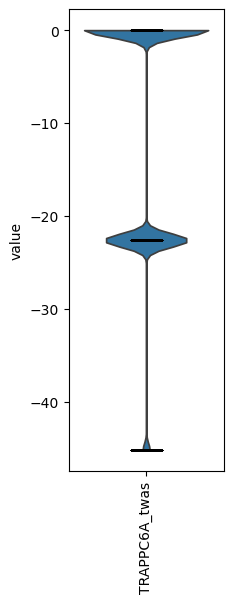

In [19]:
fig, ax = plt.subplots(figsize=(2, 6))
sc.pl.violin(adata, keys=['TRAPPC6A_twas'], rotation = 90, ax=ax)

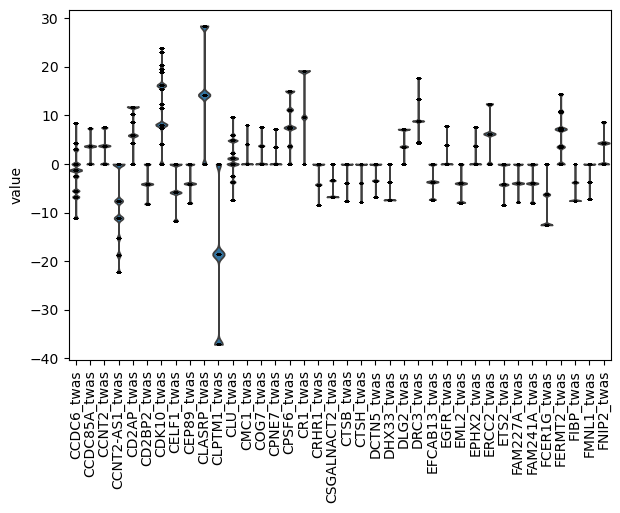

In [25]:
sc.pl.violin(adata, keys=['CCDC6_twas', 'CCDC85A_twas', 'CCNT2_twas', 'CCNT2-AS1_twas', 'CD2AP_twas', 'CD2BP2_twas', 'CDK10_twas', 'CELF1_twas', 'CEP89_twas', 
                          'CLASRP_twas', 'CLPTM1_twas', 'CLU_twas', 'CMC1_twas', 'COG7_twas', 'CPNE7_twas', 'CPSF6_twas', 'CR1_twas', 'CRHR1_twas', 'CSGALNACT2_twas', 
                          'CTSB_twas', 'CTSH_twas', 'DCTN5_twas', 'DHX33_twas', 'DLG2_twas', 'DRC3_twas', 'EFCAB13_twas', 'EGFR_twas', 'EML2_twas', 'EPHX2_twas', 
                          'ERCC2_twas', 'ETS2_twas', 'FAM227A_twas', 'FAM241A_twas', 'FCER1G_twas', 'FERMT2_twas', 'FIBP_twas', 'FMNL1_twas', 'FNIP2_twas', 
                          ], rotation = 90)

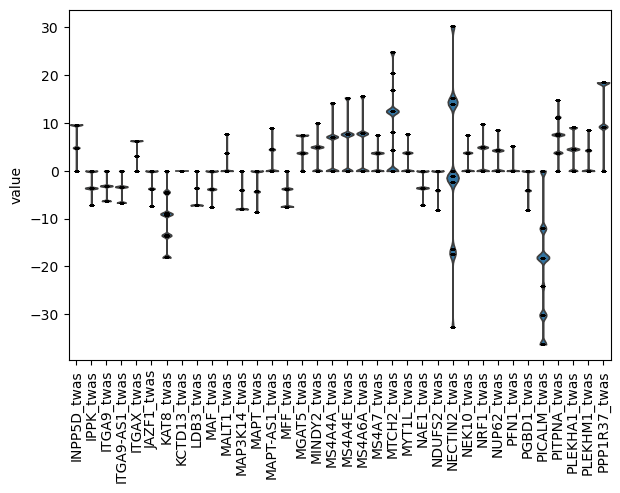

In [26]:
sc.pl.violin(adata, keys=['INPP5D_twas', 'IPPK_twas', 'ITGA9_twas', 'ITGA9-AS1_twas', 'ITGAX_twas', 'JAZF1_twas', 'KAT8_twas', 'KCTD13_twas', 'LDB3_twas', 
                          'MAF_twas', 'MALT1_twas', 'MAP3K14_twas', 'MAPT_twas', 'MAPT-AS1_twas', 'MFF_twas', 'MGAT5_twas', 'MINDY2_twas', 'MS4A4A_twas', 
                          'MS4A4E_twas', 'MS4A6A_twas', 'MS4A7_twas', 'MTCH2_twas', 'MYT1L_twas', 'NAE1_twas', 'NDUFS2_twas', 'NECTIN2_twas', 'NEK10_twas', 
                          'NRF1_twas', 'NUP62_twas', 'PFN1_twas', 'PGBD1_twas', 'PICALM_twas', 'PITPNA_twas', 'PLEKHA1_twas', 'PLEKHM1_twas', 'PPP1R37_twas', 
                          ], rotation = 90)

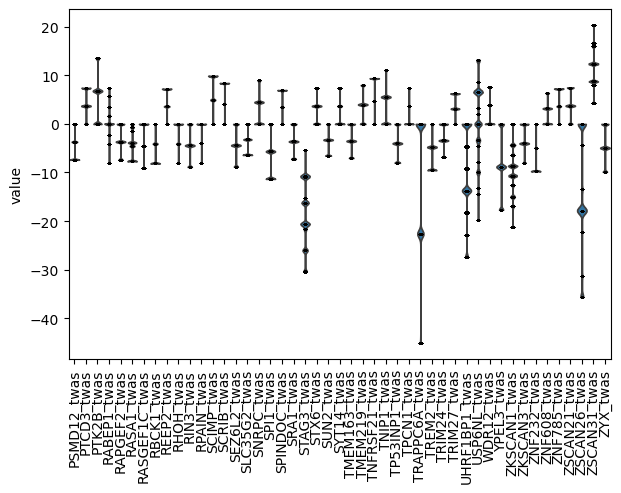

In [27]:
sc.pl.violin(adata, keys=['PSMD12_twas', 'PTCD3_twas', 'PTK2B_twas', 'RABEP1_twas', 'RAPGEF2_twas', 'RASA1_twas', 'RASGEF1C_twas', 'RBCK1_twas', 'REEP2_twas', 
                          'RHOH_twas', 'RIN3_twas', 'RPAIN_twas', 'SCIMP_twas', 'SCRIB_twas', 'SEZ6L2_twas', 'SLC35G2_twas', 'SNRPC_twas', 'SPI1_twas', 'SPINDOC_twas', 
                          'SRA1_twas', 'STAG3_twas', 'STX6_twas', 'SUN2_twas', 'SYT14_twas', 'TMEM163_twas', 'TMEM219_twas', 'TNFRSF21_twas', 'TNIP1_twas', 
                          'TP53INP1_twas', 'TPCN1_twas', 'TRAPPC6A_twas', 'TREM2_twas', 'TRIM24_twas', 'TRIM27_twas', 'UHRF1BP1_twas', 'USP6NL_twas', 'WDR12_twas', 
                          'YPEL3_twas', 'ZKSCAN1_twas', 'ZKSCAN3_twas', 'ZNF232_twas', 'ZNF608_twas', 'ZNF785_twas', 'ZSCAN21_twas', 'ZSCAN26_twas', 'ZSCAN31_twas', 
                          'ZYX_twas'], rotation = 90)

### categorizing risk scores 

In [10]:
genes

Index(['ABCA1', 'ABCA7', 'ACE', 'ADAM17', 'ADAMTS1', 'ADGRG4', 'ANK3', 'ANKH',
       'APH1B', 'APP',
       ...
       'YPEL3_twas', 'ZKSCAN1_twas', 'ZKSCAN3_twas', 'ZNF232_twas',
       'ZNF608_twas', 'ZNF785_twas', 'ZSCAN21_twas', 'ZSCAN26_twas',
       'ZSCAN31_twas', 'ZYX_twas'],
      dtype='object', length=238)

In [11]:
for gene_name in genes:
    print('************************************************************')
    print('Categorizing gene:' + gene_name)
    # Extract data
    X = np.array(adata.obs[gene_name]).reshape(-1, 1)
    
    # Determine number of peaks for GMM
    hist_vals, _ = np.histogram(X, density=True)
    peaks, _ = find_peaks(hist_vals, prominence=0.01)
    if peaks.size == 0:
        print('Warning: no peak for: ' + gene_name)
        continue
    n_components = max(peaks[-1] - 1, 1)  # Ensure n_components >= 1
    # Fit GMM and assign categories
    if n_components == 1:
        print('Warning: only one category detected for ' + gene_name)
    gmm = GaussianMixture(n_components=n_components, random_state=42).fit(X)
    data_labels = gmm.predict(X)
    
    # Rank categories from lowest to highest mean expression
    data_df = pd.DataFrame({"Expression": X.flatten(), "Category": data_labels})
    ranked_mapping = {c: i for i, c in enumerate(data_df.groupby("Category")["Expression"].mean().sort_values().index)}
    data_df["Ranked_Category"] = data_df["Category"].map(ranked_mapping)
    
    print(data_df.groupby("Ranked_Category")["Expression"].mean())
    
    # data_df["Ranked_Category"] = data_df["Ranked_Category"].astype(str) # category as string

    new_col = gene_name + '_cat'
    adata.obs[new_col] = data_df["Ranked_Category"]

************************************************************
Categorizing gene:ABCA1
Ranked_Category
0    0.0000
1    0.0438
2    0.0876
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ABCA7
Ranked_Category
0    0.0000
1    0.0833
2    0.1666
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ACE


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0538
2    0.1076
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ADAM17


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    0.055
2    0.110
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ADAMTS1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0337
2    0.0674
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ADGRG4


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -0.076
1   -0.038
2    0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ANK3


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0547
2    0.1094
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ANKH


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.1277
2    0.2554
Name: Expression, dtype: float64
************************************************************
Categorizing gene:APH1B


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0864
2    0.1728
Name: Expression, dtype: float64
************************************************************
Categorizing gene:APP


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0445
2    0.0890
Name: Expression, dtype: float64
************************************************************
Categorizing gene:BCKDK


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0392
2    0.0784
Name: Expression, dtype: float64
************************************************************
Categorizing gene:BIN1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.1444
2    0.2888
Name: Expression, dtype: float64
************************************************************
Categorizing gene:BLNK
************************************************************
Categorizing gene:CASS4


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.1132
2    0.2264
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CD2AP


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    0.097
2    0.194
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CD33
Ranked_Category
0   -21.921022
1   -10.960511
2    -5.480256
3     0.000000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CLNK
Ranked_Category
0    0.0000
1    0.0583
2    0.1166
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CLU


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0888
2    0.1776
Name: Expression, dtype: float64
************************************************************
Categorizing gene:COX7C


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0571
2    0.1142
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CR1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    0.116
2    0.232
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CTSB
Ranked_Category
0    0.0000
1    0.0549
2    0.1098
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CTSH


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0609
2    0.1218
Name: Expression, dtype: float64
************************************************************
Categorizing gene:DOC2A


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0459
2    0.0918
Name: Expression, dtype: float64
************************************************************
Categorizing gene:EED


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0947
2    0.1894
Name: Expression, dtype: float64
************************************************************
Categorizing gene:EPDR1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0542
2    0.1084
Name: Expression, dtype: float64
************************************************************
Categorizing gene:EPHA1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0384
2    0.0768
Name: Expression, dtype: float64
************************************************************
Categorizing gene:FERMT2


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.1067
2    0.2134
Name: Expression, dtype: float64
************************************************************
Categorizing gene:FOXF1
************************************************************
Categorizing gene:GRN


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0797
2    0.1594
Name: Expression, dtype: float64
************************************************************
Categorizing gene:HLA-DQA1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0662
2    0.1324
Name: Expression, dtype: float64
************************************************************
Categorizing gene:HS3ST5


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0389
2    0.0778
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ICA1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0643
2    0.1286
Name: Expression, dtype: float64
************************************************************
Categorizing gene:IGH gene cluster
Ranked_Category
0    0.000000
1    0.039700
2    0.061800
3    0.101500
4    0.124749
5    0.163300
6    0.203000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:IL34


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0861
2    0.1722
Name: Expression, dtype: float64
************************************************************
Categorizing gene:INPP5D


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0419
2    0.0838
Name: Expression, dtype: float64
************************************************************
Categorizing gene:LILRB2


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0509
2    0.1018
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MAF


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0252
2    0.0504
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MID1
************************************************************
Categorizing gene:MINDY2


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    0.053
2    0.106
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MME


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0861
2    0.1722
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MS4A4A


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.1181
2    0.2362
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MTM1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    0.045
2    0.090
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MYO15A


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0708
2    0.1416
Name: Expression, dtype: float64
************************************************************
Categorizing gene:NLGN4X


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -0.692
1   -0.346
2    0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:PLCG2


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0375
2    0.0750
Name: Expression, dtype: float64
************************************************************
Categorizing gene:PLEKHA1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0457
2    0.0914
Name: Expression, dtype: float64
************************************************************
Categorizing gene:PRDM7


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.1025
2    0.2050
Name: Expression, dtype: float64
************************************************************
Categorizing gene:PRKD3


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0623
2    0.1246
Name: Expression, dtype: float64
************************************************************
Categorizing gene:PTK2B


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0715
2    0.1430
Name: Expression, dtype: float64
************************************************************
Categorizing gene:RASGEF1C


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    0.086
2    0.172
Name: Expression, dtype: float64
************************************************************
Categorizing gene:RBCK1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0457
2    0.0914
Name: Expression, dtype: float64
************************************************************
Categorizing gene:RHOH


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0448
2    0.0896
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SCIMP


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0461
2    0.0922
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SEC61G


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0602
2    0.1204
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SHARPIN


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.1325
2    0.2650
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SIGLEC11
Ranked_Category
0    0.0000
1    0.0549
2    0.1098
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SLC24A4
Ranked_Category
0    0.000000
1    0.038700
2    0.066343
3    0.104100
4    0.133533
5    0.169500
6    0.208200
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SLC2A4RG


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0604
2    0.1208
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SLC9A7


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    0.028
2    0.056
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SNX1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    0.065
2    0.130
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SORL1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.1961
2    0.3922
3    0.5002
4    0.6082
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SPDYE3


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0816
2    0.1632
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SPI1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0498
2    0.0996
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SPPL2A


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0593
2    0.1186
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TMEM106B


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    0.053
2    0.106
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TNIP1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0445
2    0.0890
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TPCN1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0754
2    0.1508
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TREML2


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TSPAN14


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0704
2    0.1408
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TSPOAP1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0547
2    0.1094
Name: Expression, dtype: float64
************************************************************
Categorizing gene:UMAD1


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0496
2    0.0992
Name: Expression, dtype: float64
************************************************************
Categorizing gene:UNC5CL


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0711
2    0.1422
Name: Expression, dtype: float64
************************************************************
Categorizing gene:USP6NL


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0662
2    0.1324
Name: Expression, dtype: float64
************************************************************
Categorizing gene:WNT3


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    0.0703
2    0.1406
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ZNF280C


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    0.031
2    0.062
Name: Expression, dtype: float64
************************************************************
Categorizing gene:AC004797.1_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0     0.000
1     5.396
2    10.792
Name: Expression, dtype: float64
************************************************************
Categorizing gene:AC005225.2_twas
Ranked_Category
0   -7.47810
1   -3.73905
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:AC008105.3_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.72246
1   -4.36123
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:AC010976.1_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -10.44456
1    -5.22228
2     0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:AC013643.2_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.60596
1   -4.30298
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:AC087500.1_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    4.05726
2    8.11452
Name: Expression, dtype: float64
************************************************************
Categorizing gene:AC097662.1_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    3.68711
2    7.37422
Name: Expression, dtype: float64
************************************************************
Categorizing gene:AC139887.2_twas
Ranked_Category
0    0.000000
1    3.791915
2    7.583830
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ACE_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -10.342
1    -5.171
2     0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ACOT2_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.37234
1   -3.68617
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ADAM10_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0     0.00000
1     6.30917
2    12.61834
Name: Expression, dtype: float64
************************************************************
Categorizing gene:AL049637.1_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.090
1   -3.545
2    0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:AL162431.1_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    3.608
2    7.216
Name: Expression, dtype: float64
************************************************************
Categorizing gene:AL162511.1_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.648078
1   -3.824039
2    0.000000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:AL596218.1_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0     0.000
1    10.032
2    20.064
Name: Expression, dtype: float64
************************************************************
Categorizing gene:AP001439.1_twas
Ranked_Category
0     0.000000
1     5.221000
2     9.636679
3    12.973994
4    18.057200
5    25.672400
Name: Expression, dtype: float64
************************************************************
Categorizing gene:AP4M1_twas
Ranked_Category
0   -9.390000
1   -4.712597
2   -0.897169
3    0.000000
4    3.776038
5    7.604142
Name: Expression, dtype: float64
************************************************************
Categorizing gene:APH1B_twas
Ranked_Category
0     0.00000
1    11.31365
2    22.62730
Name: Expression, dtype: float64
************************************************************
Categorizing gene:APOC1_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    3.165
2    6.330
Name: Expression, dtype: float64
************************************************************
Categorizing gene:APOE_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0     0.000
1     7.765
2    15.530
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ARHGAP31_twas
Ranked_Category
0   -6.4782
1   -3.2391
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ARL17B_twas
Ranked_Category
0   -16.531600
1   -12.373469
2    -8.156212
3     0.000000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ASPHD1_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -6.90
1   -3.45
2    0.00
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ATP5MC2_twas


/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    3.5359
2    7.0718
Name: Expression, dtype: float64
************************************************************
Categorizing gene:BCL7C_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.466
1   -4.233
2    0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:BIN1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -16.594000
1    -8.297000
2    -0.893048
3     7.308000
4    15.637183
Name: Expression, dtype: float64
************************************************************
Categorizing gene:C1QBP_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.3172
1   -4.1586
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:C1QTNF4_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0     0.00000
1     5.04131
2    10.08262
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CARF_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0     0.000000
1     3.947602
2     7.779990
3    15.559980
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CASS4_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -14.196
1    -7.098
2     0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CASTOR3_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.81838
1   -3.90919
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CBY1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000000
1    3.886995
2    7.773990
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CCDC189_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0    0.0
1    3.9
2    7.8
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CCDC6_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -11.014000
1    -6.133290
2    -1.608561
3     0.000000
4     3.458465
5     8.497000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CCDC85A_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    3.68611
2    7.37222
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CCNT2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    3.76003
2    7.52006
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CCNT2-AS1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -18.342118
1   -11.127680
2    -7.584900
3     0.000000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CD2AP_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0     0.000000
1     5.792289
2    10.149285
3    11.804600
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CD2BP2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.21528
1   -4.10764
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CDK10_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0     0.000000
1     4.168400
2     7.355200
3     8.096550
4    11.757396
5    16.193100
6    19.697505
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CELF1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -11.696
1    -5.848
2     0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CEP89_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.04722
1   -4.02361
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CLASRP_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0     0.00000
1    14.22436
2    28.44872
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CLPTM1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -37.12152
1   -18.56076
2     0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CLU_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -3.470192
1    0.000000
2    1.400257
3    4.840000
4    5.999600
5    9.680000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CMC1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    4.05075
2    8.10150
Name: Expression, dtype: float64
************************************************************
Categorizing gene:COG7_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00
1    3.77
2    7.54
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CPNE7_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0    0.0000
1    3.5848
2    7.1696
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CPSF6_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0     0.00000
1     3.67465
2     7.34930
3     7.52085
4    11.19550
5    15.04170
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CR1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0     0.000000
1     9.620197
2    19.240394
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CRHR1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.444
1   -4.222
2    0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CSGALNACT2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -6.768
1   -3.384
2    0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CTSB_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.63930
1   -3.81965
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:CTSH_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.79864
1   -3.89932
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:DCTN5_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -6.82
1   -3.41
2    0.00
Name: Expression, dtype: float64
************************************************************
Categorizing gene:DHX33_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.39970
1   -3.69985
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:DLG2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000000
1    3.592572
2    7.185144
Name: Expression, dtype: float64
************************************************************
Categorizing gene:DRC3_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0     4.426148
1     8.814000
2     8.891877
3    13.309671
4    17.758000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:EFCAB13_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.326
1   -3.663
2    0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:EGFR_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    3.86968
2    7.73936
Name: Expression, dtype: float64
************************************************************
Categorizing gene:EML2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -7.92988
1   -3.96494
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:EPHX2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    3.79307
2    7.58614
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ERCC2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0     0.0000
1     6.2135
2    12.4270
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ETS2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.426
1   -4.213
2    0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:FAM227A_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.898
1   -3.949
2    0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:FAM241A_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.9486
1   -3.9743
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:FCER1G_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -12.5338
1    -6.2669
2     0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:FERMT2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0     0.000000
1     3.535290
2     3.694000
3     7.207786
4    10.789957
5    14.458580
Name: Expression, dtype: float64
************************************************************
Categorizing gene:FIBP_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.544
1   -3.772
2    0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:FMNL1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.2504
1   -3.6252
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:FNIP2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    4.328
2    8.656
Name: Expression, dtype: float64
************************************************************
Categorizing gene:GGA2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -14.915380
1   -11.198603
2    -7.500000
3    -7.452199
4    -3.747081
5     0.000000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:GPATCH8_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    3.69208
2    7.38416
Name: Expression, dtype: float64
************************************************************
Categorizing gene:GRN_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -11.294
1    -5.647
2     0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:HEATR4_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.316218
1   -4.158109
2    0.000000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:HOOK2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -6.8816
1   -3.4408
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:HTRA1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    4.0265
2    8.0530
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ICA1L_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0     0.00000
1     7.53227
2    15.06454
Name: Expression, dtype: float64
************************************************************
Categorizing gene:IL34_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.82
1   -3.91
2    0.00
Name: Expression, dtype: float64
************************************************************
Categorizing gene:INO80E_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0     0.000000
1     5.497097
2    12.778480
3    17.009480
4    25.425589
Name: Expression, dtype: float64
************************************************************
Categorizing gene:INPP5D_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    4.829
2    9.658
Name: Expression, dtype: float64
************************************************************
Categorizing gene:IPPK_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.2114
1   -3.6057
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ITGA9_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -6.3058
1   -3.1529
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ITGA9-AS1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -6.66
1   -3.33
2    0.00
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ITGAX_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    3.1501
2    6.3002
Name: Expression, dtype: float64
************************************************************
Categorizing gene:JAZF1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.4536
1   -3.7268
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:KAT8_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -18.116200
1   -13.492532
2    -9.062947
3    -8.800000
4    -4.436568
5     0.000000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:KCTD13_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0
Name: Expression, dtype: float64
************************************************************
Categorizing gene:LDB3_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.1990
1   -3.5995
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MAF_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.63798
1   -3.81899
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MALT1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    3.79667
2    7.59334
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MAP3K14_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.00930
1   -4.00465
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MAPT_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.66
1   -4.33
2    0.00
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MAPT-AS1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    4.481
2    8.962
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MFF_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.48706
1   -3.74353
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MGAT5_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    3.749
2    7.498
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MINDY2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    4.98336
2    9.96672
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MS4A4A_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0     0.0000
1     7.1136
2    14.2272
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MS4A4E_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0     0.0000
1     7.6586
2    15.3172
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MS4A6A_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0     0.000
1     7.797
2    15.594
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MS4A7_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    3.7427
2    7.4854
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MTCH2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0     0.000000
1     5.402849
2    12.632150
3    24.649063
Name: Expression, dtype: float64
************************************************************
Categorizing gene:MYT1L_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    3.79422
2    7.58844
Name: Expression, dtype: float64
************************************************************
Categorizing gene:NAE1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.14
1   -3.57
2    0.00
Name: Expression, dtype: float64
************************************************************
Categorizing gene:NDUFS2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.22
1   -4.11
2    0.00
Name: Expression, dtype: float64
************************************************************
Categorizing gene:NECTIN2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -32.606300
1   -17.046237
2    -2.264300
3    -1.067708
4    14.394099
5    30.342000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:NEK10_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    3.7908
2    7.5816
Name: Expression, dtype: float64
************************************************************
Categorizing gene:NRF1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    4.925
2    9.850
Name: Expression, dtype: float64
************************************************************
Categorizing gene:NUP62_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    4.29205
2    8.58410
Name: Expression, dtype: float64
************************************************************
Categorizing gene:PFN1_twas
************************************************************
Categorizing gene:PGBD1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.2078
1   -4.1039
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:PICALM_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -31.888289
1   -18.133300
2   -12.041300
3     0.000000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:PITPNA_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0     0.000000
1     3.800440
2     7.434440
3     7.600880
4    11.227394
5    14.868880
Name: Expression, dtype: float64
************************************************************
Categorizing gene:PLEKHA1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    4.539
2    9.078
Name: Expression, dtype: float64
************************************************************
Categorizing gene:PLEKHM1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    4.2839
2    8.5678
Name: Expression, dtype: float64
************************************************************
Categorizing gene:PPP1R37_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0     0.0000
1     9.2356
2    18.4712
Name: Expression, dtype: float64
************************************************************
Categorizing gene:PSMD12_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.3612
1   -3.6806
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:PTCD3_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    3.718
2    7.436
Name: Expression, dtype: float64
************************************************************
Categorizing gene:PTK2B_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0     0.000000
1     6.807231
2    13.614462
Name: Expression, dtype: float64
************************************************************
Categorizing gene:RABEP1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -4.175509
1    0.000000
2    1.701930
3    5.323560
Name: Expression, dtype: float64
************************************************************
Categorizing gene:RAPGEF2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.324
1   -3.662
2    0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:RASA1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -7.678200
1   -4.543200
2   -3.839100
3   -0.477061
Name: Expression, dtype: float64
************************************************************
Categorizing gene:RASGEF1C_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -9.0576
1   -4.5288
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:RBCK1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.1372
1   -4.0686
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:REEP2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    3.6243
2    7.2486
Name: Expression, dtype: float64
************************************************************
Categorizing gene:RHOH_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.1396
1   -4.0698
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:RIN3_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.843114
1   -4.421557
2    0.000000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:RPAIN_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.9444
1   -3.9722
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SCIMP_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    4.96128
2    9.92256
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SCRIB_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    4.212
2    8.424
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SEZ6L2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.78524
1   -4.39262
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SLC35G2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -6.372
1   -3.186
2    0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SNRPC_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    4.48762
2    8.97524
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SPI1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -11.30474
1    -5.65237
2     0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SPINDOC_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    3.48481
2    6.96962
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SRA1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.2092
1   -3.6046
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:STAG3_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -30.419583
1   -26.050325
2   -20.826511
3   -16.199499
4   -10.804009
5    -5.401400
Name: Expression, dtype: float64
************************************************************
Categorizing gene:STX6_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000000
1    3.705205
2    7.410410
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SUN2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -6.5246
1   -3.2623
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:SYT14_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    3.68988
2    7.37976
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TMEM163_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.018
1   -3.509
2    0.000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TMEM219_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00
1    4.01
2    8.02
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TNFRSF21_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00000
1    4.70597
2    9.41194
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TNIP1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0     0.000
1     5.566
2    11.132
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TP53INP1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -7.98328
1   -3.99164
2    0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TPCN1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000
1    3.713
2    7.426
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TRAPPC6A_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -45.23136
1   -22.61568
2     0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TREM2_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -9.5150
1   -4.7575
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TRIM24_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -6.8068
1   -3.4034
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:TRIM27_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.00
1    3.14
2    6.28
Name: Expression, dtype: float64
************************************************************
Categorizing gene:UHRF1BP1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -27.444860
1   -13.722430
2    -9.366043
3     0.000000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:USP6NL_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -19.863660
1   -13.966359
2    -9.725662
3    -3.599027
4     0.627828
5     6.604000
6    13.208000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:WDR12_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0    0.00000
1    3.85908
2    7.71816
Name: Expression, dtype: float64
************************************************************
Categorizing gene:YPEL3_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -17.67458
1    -8.83729
2     0.00000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ZKSCAN1_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -21.332600
1   -14.969054
2   -10.666300
3    -8.655600
4    -4.879102
5     0.000000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ZKSCAN3_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -8.0096
1   -4.0048
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ZNF232_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -9.7390
1   -4.8695
2    0.0000
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ZNF608_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    3.1979
2    6.3958
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ZNF785_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.0000
1    3.6437
2    7.2874
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ZSCAN21_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0    0.000000
1    3.755981
2    7.511962
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ZSCAN26_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0   -34.681643
1   -17.972993
2   -13.489800
3    -0.256497
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ZSCAN31_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


Ranked_Category
0     4.388000
1     8.741437
2    12.397400
3    16.018800
4    16.785400
5    20.406800
Name: Expression, dtype: float64
************************************************************
Categorizing gene:ZYX_twas


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]
/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Ranked_Category
0   -9.8614
1   -4.9307
2    0.0000
Name: Expression, dtype: float64


/tmp/ipykernel_2505692/818212574.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[new_col] = data_df["Ranked_Category"]


In [12]:
adata.obs

,nCount_RNA,nFeature_RNA,nCount_SCT,nFeature_SCT,batch,individualID,DoubletFinder.score,subset,class,state,...,YPEL3_twas_cat,ZKSCAN1_twas_cat,ZKSCAN3_twas_cat,ZNF232_twas_cat,ZNF608_twas_cat,ZNF785_twas_cat,ZSCAN21_twas_cat,ZSCAN26_twas_cat,ZSCAN31_twas_cat,ZYX_twas_cat
0,3903.0,2046,3514.0,2046,190403-B4-A,R4119160,0.00,Microglia,1,Mic.1,...,1,1,2,0,1,2,1,3,1,1
1,3758.0,2136,3512.0,2136,190403-B4-A,R4641987,0.00,Microglia,1,Mic.13,...,1,1,2,0,2,2,1,3,1,2
2,3668.0,1861,3446.0,1861,190403-B4-A,R5693901,0.02,Microglia,1,Mic.13,...,1,1,1,1,1,2,0,1,2,2
3,3396.0,2017,3326.0,2017,190403-B4-A,R9116123,0.00,Microglia,1,Mic.7,...,1,2,1,0,1,2,1,1,2,2
4,3268.0,1959,3239.0,1959,190403-B4-A,R2670295,0.00,Microglia,1,Mic.12,...,1,3,1,0,0,2,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581194,5807.0,3277,4577.0,3258,201028-B62-B,R4928630,0.51,Endothelial,Immune,Neutrophils,...,1,3,2,0,0,2,1,2,1,1
1581195,6314.0,2843,4553.0,2748,201207-B63-A,R1933335,0.50,Endothelial,Immune,Erythrocytes,...,0,3,1,0,1,2,1,1,1,1
1581196,2222.0,1385,3006.0,1386,201207-B63-A,R1933335,0.40,Endothelial,Immune,Neutrophils,...,0,3,1,0,1,2,1,1,1,1
1581197,1606.0,1257,3104.0,1268,201207-B63-A,R4516201,0.41,Endothelial,Immune,Erythrocytes,...,2,5,0,0,2,1,2,1,5,2


In [13]:
adata.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_ready_variant_cat.h5ad')

In [15]:
adata.obs.dtypes

nCount_RNA           float64
nFeature_RNA           int32
nCount_SCT           float64
nFeature_SCT           int32
batch               category
                      ...   
ZNF785_twas_cat        int64
ZSCAN21_twas_cat       int64
ZSCAN26_twas_cat       int64
ZSCAN31_twas_cat       int64
ZYX_twas_cat           int64
Length: 504, dtype: object

In [1]:
# plt.hist(list(adata.obs.BLNK))

In [3]:
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_ready_variant_cat.h5ad')

/home/icb/zihe.zheng/miniconda3/envs/scanpy_dask/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
adata.obs

,nCount_RNA,nFeature_RNA,nCount_SCT,nFeature_SCT,batch,individualID,DoubletFinder.score,subset,class,state,...,YPEL3_twas_cat,ZKSCAN1_twas_cat,ZKSCAN3_twas_cat,ZNF232_twas_cat,ZNF608_twas_cat,ZNF785_twas_cat,ZSCAN21_twas_cat,ZSCAN26_twas_cat,ZSCAN31_twas_cat,ZYX_twas_cat
0,3903.0,2046,3514.0,2046,190403-B4-A,R4119160,0.00,Microglia,1,Mic.1,...,1,1,2,0,1,2,1,3,1,1
1,3758.0,2136,3512.0,2136,190403-B4-A,R4641987,0.00,Microglia,1,Mic.13,...,1,1,2,0,2,2,1,3,1,2
2,3668.0,1861,3446.0,1861,190403-B4-A,R5693901,0.02,Microglia,1,Mic.13,...,1,1,1,1,1,2,0,1,2,2
3,3396.0,2017,3326.0,2017,190403-B4-A,R9116123,0.00,Microglia,1,Mic.7,...,1,2,1,0,1,2,1,1,2,2
4,3268.0,1959,3239.0,1959,190403-B4-A,R2670295,0.00,Microglia,1,Mic.12,...,1,3,1,0,0,2,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581194,5807.0,3277,4577.0,3258,201028-B62-B,R4928630,0.51,Endothelial,Immune,Neutrophils,...,1,3,2,0,0,2,1,2,1,1
1581195,6314.0,2843,4553.0,2748,201207-B63-A,R1933335,0.50,Endothelial,Immune,Erythrocytes,...,0,3,1,0,1,2,1,1,1,1
1581196,2222.0,1385,3006.0,1386,201207-B63-A,R1933335,0.40,Endothelial,Immune,Neutrophils,...,0,3,1,0,1,2,1,1,1,1
1581197,1606.0,1257,3104.0,1268,201207-B63-A,R4516201,0.41,Endothelial,Immune,Erythrocytes,...,2,5,0,0,2,1,2,1,5,2
